# Image Captioning — BUTD (full pipeline)

Notebook chuẩn: đọc dữ liệu SCAN COCO precomp, build vocab từ COCO, dựng dataloader, định nghĩa model UpDown (BUTD 2-LSTM), huấn luyện XE (OneCycleLR + AdamW + label smoothing), lưu checkpoint, vẽ đồ thị, dự đoán trên validation và đánh giá COCO (Bleu/METEOR/CIDEr/SPICE).

Hãy chạy tuần tự các ô. Các đường dẫn mặc định lấy từ: `/kaggle/input/scan-features/data/data/coco_precomp` và `/kaggle/working/coco`.

Chỉnh `CFG` cell nếu cần.

In [ ]:
# --- 1. CÀI ĐẶT THƯ VIỆN ---
!pip install -q pycocotools pycocoevalcap underthesea transformers sentencepiece

# --- 2. IMPORT THƯ VIỆN HỆ THỐNG & TIỆN ÍCH ---
import os
import sys
import json
import re
import time
import random
import contextlib
from pathlib import Path
from collections import Counter, defaultdict
from dataclasses import dataclass

# --- 3. IMPORT THƯ VIỆN TÍNH TOÁN & ĐỒ THỊ ---
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- 4. IMPORT THƯ VIỆN DEEP LEARNING (PYTORCH) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from torch.amp import autocast, GradScaler 

# --- 5. IMPORT THƯ VIỆN ĐÁNH GIÁ (COCO METRICS) ---
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
from pycocoevalcap.cider.cider import Cider
from underthesea import word_tokenize

# --- 6. CẤU HÌNH HỆ THỐNG & THIẾT BỊ ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

print(f'✅ Hệ thống sẵn sàng!')
print(f'   - Device: {DEVICE}')
print(f'   - Torch Version: {torch.__version__}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.6/978.6 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 127.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.8.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1

In [ ]:
# ==========================================================
# ---------------- CONFIG (CHỈNH TẠI ĐÂY) ----------------
# ==========================================================

# 1. QUẢN LÝ ĐƯỜNG DẪN (PATHS)
ROOT_INPUT      = Path('/kaggle/input')
ROOT_SCAN       = ROOT_INPUT / 'scan-features/data/data/coco_precomp'
VI_CAPS_DIR     = ROOT_INPUT / 'captions-vi'
OUT_DIR         = Path('/kaggle/working')

# Thư mục xuất dữ liệu (Vocab, Checkpoints, JSON)
OUT_DIR.mkdir(parents=True, exist_ok=True)
COCO_OUT        = OUT_DIR / 'coco'
COCO_OUT.mkdir(parents=True, exist_ok=True)

# File cụ thể
PATH_EN_CAPS    = ROOT_SCAN / 'train_caps.txt'
PATH_VI_CAPS    = VI_CAPS_DIR / 'train_caps_vi.txt'
VOCAB_FILE      = PATH_VI_CAPS
SAVE_PATH_JSON  = OUT_DIR / "vocab_butd.json"
VAL_JSON        = OUT_DIR / "coco_json/captions_val2014.json"

# Checkpoint để Load fine-tuning
CE_CHECKPOINT_PATH = VI_CAPS_DIR / "butd_vietnamese_best.pt"

# 2. THIẾT LẬP HỆ THỐNG
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED            = 42
MAXLEN          = 30     # Độ dài tối đa của câu mô tả
WORKERS         = 4      # Số luồng xử lý CPU
PIN_MEMORY      = False  # True nếu dùng GPU mạnh và RAM dư dả

# 3. THÔNG SỐ HUẤN LUYỆN (HYPERPARAMETERS)
# Giai đoạn 1: Cross-Entropy (CE)
BATCH_TRAIN     = 128
EPOCHS          = 10
ONECYCLE_MAX_LR = 3e-4

# Giai đoạn 2: Self-Critical Sequence Training (SCST)
BATCH_SCST      = 86     # Batch lớn để tính Baseline SCST ổn định hơn
FT_EPOCHS       = 10     # Số epoch fine-tuning
FT_LR           = 1e-4   # Learning rate thấp cho fine-tuning
WEIGHT_DECAY    = 1e-5

# 4. ĐÁNH GIÁ (EVALUATION)
N_EVAL          = 1      # Đánh giá sau mỗi N epoch
BATCH_IMG       = 128    # Batch size khi trích xuất hoặc eval ảnh

# Khởi tạo Seed một lần duy nhất
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f'✅ Config Loaded!')
print(f'   - Scan Dir: {ROOT_SCAN}')
print(f'   - Device: {DEVICE}')

SCAN_DIR /kaggle/input/scan-features/data/data/coco_precomp


In [ ]:




def verify_mapping(n_samples=10):
    if not PATH_VI_CAPS.exists():
        print(f"Lỗi: Không tìm thấy file Tiếng Việt tại {PATH_VI_CAPS}")
        return

    # 1. Đọc nội dung cả hai file
    with open(PATH_EN_CAPS, 'r', encoding='utf-8') as f:
        en_lines = [line.strip() for line in f]
    
    with open(PATH_VI_CAPS, 'r', encoding='utf-8') as f:
        vi_lines = [line.strip() for line in f]

    # 2. Kiểm tra độ dài
    print(f"--- KIỂM TRA ĐỘ DÀI ---")
    print(f"Số lượng câu Tiếng Anh: {len(en_lines)}")
    print(f"Số lượng câu Tiếng Việt: {len(vi_lines)}")
    
    if len(en_lines) != len(vi_lines):
        print("⚠️ CẢNH BÁO: Số lượng dòng không khớp! Mapping có thể bị lệch.")
    else:
        print("✅ Độ dài khớp nhau hoàn toàn.")
    print("-" * 50)

    # 3. Lấy mẫu ngẫu nhiên để so sánh
    print(f"--- SO SÁNH NGẪU NHIÊN {n_samples} CẶP CÂU ---")
    total = min(len(en_lines), len(vi_lines))
    indices = random.sample(range(total), n_samples)

    for i, idx in enumerate(indices):
        # Tính toán Image Index (vì 5 câu ứng với 1 ảnh)
        img_idx = idx // 5 
        print(f"Mẫu {i+1} [Dòng: {idx} | Thuộc ảnh thứ: {img_idx}]")
        print(f"  [EN]: {en_lines[idx]}")
        print(f"  [VI]: {vi_lines[idx]}")
        print("-" * 30)

# Chạy kiểm chứng
verify_mapping(n_samples=5)

--- KIỂM TRA ĐỘ DÀI ---
Số lượng câu Tiếng Anh: 566435
Số lượng câu Tiếng Việt: 566435
✅ Độ dài khớp nhau hoàn toàn.
--------------------------------------------------
--- SO SÁNH NGẪU NHIÊN 5 CẶP CÂU ---
Mẫu 1 [Dòng: 116739 | Thuộc ảnh thứ: 23347]
  [EN]: a woman holding a wil controller with a steering wheel
  [VI]: một người phụ nữ cầm một bộ điều khiển quét với bánh lái
------------------------------
Mẫu 2 [Dòng: 26225 | Thuộc ảnh thứ: 5245]
  [EN]: A man riding a motorcycle down a street next to a restaurant .
  [VI]: một người đàn ông đang đi xe máy xuống đường bên cạnh một nhà hàng .
------------------------------
Mẫu 3 [Dòng: 288389 | Thuộc ảnh thứ: 57677]
  [EN]: A street sign on the city streets of Houston and Luldlow .
  [VI]: một biển hiệu trên đường phố houston và luldlow .
------------------------------
Mẫu 4 [Dòng: 256787 | Thuộc ảnh thứ: 51357]
  [EN]: A large blue and white airplane on an airport runway .
  [VI]: một chiếc máy bay lớn màu xanh và trắng trên đường băng 

In [ ]:




# 2. Các token đặc biệt
SPECIAL_TOKENS = {
    "pad": "<pad>",
    "bos": "<s>",
    "eos": "</s>",
    "unk": "<unk>"
}

def build_and_save_json_vocab(file_path, save_path, min_freq=1):
    print(f"--- Đang build vocab từ: {file_path} ---")
    counter = Counter()
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Tách lấy phần caption sau dấu cách đầu tiên (bỏ qua image_id nếu có)
            parts = line.strip().split(maxsplit=1)
            caption = parts[1].lower() if len(parts) > 1 else parts[0].lower()
            tokens = caption.split()
            counter.update(tokens)

    # Khởi tạo itos với các token đặc biệt
    itos = [SPECIAL_TOKENS["pad"], SPECIAL_TOKENS["bos"], 
            SPECIAL_TOKENS["eos"], SPECIAL_TOKENS["unk"]]
    
    # Lấy các từ thỏa mãn tần suất (đã giảm min_freq xuống 1 để tăng lượng từ)
    added_words = [word for word, count in counter.most_common() if count >= min_freq]
    itos.extend(added_words)
    
    # Tạo mapping stoi
    stoi = {word: i for i, word in enumerate(itos)}
    
    # 3. Cấu trúc dữ liệu để lưu JSON
    vocab_dict = {
        "info": {
            "min_freq": min_freq,
            "vocab_size": len(itos),
            "total_tokens_found": sum(counter.values())
        },
        "itos": itos,
        "stoi": stoi
    }
    
    # Lưu file JSON với ensure_ascii=False để đọc được tiếng Việt có dấu
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(vocab_dict, f, ensure_ascii=False, indent=4)
        
    print(f"✅ Đã lưu JSON tại: {save_path}")
    print(f"Kích thước Vocab mới: {len(itos)} từ (với min_freq={min_freq})")
    return itos, stoi

# Thực thi và lấy lại các hằng số
itos, stoi = build_and_save_json_vocab(VOCAB_FILE, SAVE_PATH_JSON, min_freq=1)

PAD = stoi[SPECIAL_TOKENS["pad"]]
BOS = stoi[SPECIAL_TOKENS["bos"]]
EOS = stoi[SPECIAL_TOKENS["eos"]]
UNK = stoi[SPECIAL_TOKENS["unk"]]
VOCAB_SIZE = len(itos)

# Xem thử 10 từ đầu tiên sau các token đặc biệt
print(f"10 từ phổ biến nhất: {itos[4:14]}")


--- Đang build vocab từ: /kaggle/input/captions-vi/train_caps_vi.txt ---
✅ Đã lưu JSON tại: /kaggle/working/vocab_butd.json
Kích thước Vocab mới: 9158 từ (với min_freq=1)
10 từ phổ biến nhất: ['.', 'một', 'trên', 'người', 'con', 'và', 'đang', 'với', 'trong', 'chiếc']


In [ ]:


def read_lines(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

# 2. NẠP DỮ LIỆU GỐC
print("📂 Đang nạp dữ liệu thô...")

# Nạp IDs (từ SCAN)
train_ids_raw = read_lines(SCAN_DIR / 'train_ids.txt')
dev_ids_raw   = read_lines(SCAN_DIR / 'testall_ids.txt')
test_ids_raw  = read_lines(SCAN_DIR / 'test_ids.txt')

# Nạp Captions Tiếng Việt (từ dataset của bạn)
# Lưu ý: Đảm bảo tên file khớp với thực tế bạn đã lưu
train_caps_vi = read_lines(VI_CAPS_DIR / 'train_caps_vi.txt')
dev_caps_vi   = read_lines(VI_CAPS_DIR / 'testall_caps_vi.txt')
test_caps_vi  = read_lines(VI_CAPS_DIR / 'test_caps_vi.txt')

# 3. LOGIC REPEAT ID (Đồng bộ 1 ảnh - 5 câu)
def align_caps_and_ids(caps, ids_raw):
    # Nếu file ID chỉ chứa ID ảnh (ví dụ 29k dòng) nhưng Caps có 145k dòng
    if len(ids_raw) * 5 == len(caps):
        return np.repeat(ids_raw, 5).tolist()
    return ids_raw

train_cap2img = align_caps_and_ids(train_caps_vi, train_ids_raw)
dev_cap2img   = align_caps_and_ids(dev_caps_vi, dev_ids_raw)
test_cap2img  = align_caps_and_ids(test_caps_vi, test_ids_raw)

# 4. HÀM BUILD COCO JSON CHUẨN
def build_coco_json(split_name, caps, ids, out_dir):
    """
    Xây dựng file JSON chuẩn COCO từ danh sách câu và ID tương ứng.
    """
    # Lấy danh sách ID ảnh duy nhất để tạo mapping
    # Dùng list(dict.fromkeys) để giữ nguyên thứ tự xuất hiện (quan trọng cho mmap)
    uniq_idx = list(dict.fromkeys(ids))
    
    # Mapping ID gốc (string/int) sang ID số nguyên (COCO API bắt buộc)
    idx2imgid = {idx: i + 1 for i, idx in enumerate(uniq_idx)}
    
    # Tạo cấu trúc 'images'
    images = [
        {
            "id": idx2imgid[idx], 
            "file_name": f"{idx}.jpg", 
            "height": 0, 
            "width": 0
        } for idx in uniq_idx
    ]
    
    # Tạo cấu trúc 'annotations'
    anns = []
    for aid, (c, idx) in enumerate(zip(caps, ids), 1):
        # Loại bỏ prefix ID nếu file text của bạn có dạng "id#0 caption"
        caption_clean = c.split(maxsplit=1)[-1] if '#' in c else c
        
        anns.append({
            "id": aid, 
            "image_id": idx2imgid[idx], 
            "caption": caption_clean
        })
        
    # Định dạng tên file theo chuẩn COCO 2014
    fname = {
        'train': 'captions_train2014.json',
        'dev': 'captions_val2014.json',
        'test': 'captions_test2014.json'
    }[split_name]
    
    out_path = out_dir / fname
    
    with open(out_path, 'w', encoding='utf-8') as f:
        json.dump({
            "images": images, 
            "annotations": anns, 
            "type": "captions", 
            "licenses": [], 
            "info": {}
        }, f, ensure_ascii=False, indent=4)
        
    print(f"✅ Đã ghi: {out_path} | Images: {len(images)} | Anns: {len(anns)}")
    return out_path

# 5. THỰC THI TẠO 3 FILE
print("\n🛠 Đang khởi tạo các file JSON COCO...")

if not (COCO_OUT / 'captions_train2014.json').exists():
    build_coco_json('train', train_caps_vi, train_cap2img, COCO_OUT)

if not (COCO_OUT / 'captions_val2014.json').exists():
    VAL_JSON = build_coco_json('dev', dev_caps_vi, dev_cap2img, COCO_OUT)
else:
    VAL_JSON = COCO_OUT / 'captions_val2014.json'

if not (COCO_OUT / 'captions_test2014.json').exists():
    TEST_JSON = build_coco_json('test', test_caps_vi, test_cap2img, COCO_OUT)
else:
    TEST_JSON = COCO_OUT / 'captions_test2014.json'

print(f"\n🚀 Hoàn tất! Biến VAL_JSON hiện đang trỏ tới: {VAL_JSON}")

📂 Đang nạp dữ liệu thô...

🛠 Đang khởi tạo các file JSON COCO...
✅ Đã ghi: /kaggle/working/coco/captions_train2014.json | Images: 113287 | Anns: 566435
✅ Đã ghi: /kaggle/working/coco/captions_val2014.json | Images: 5000 | Anns: 25000
✅ Đã ghi: /kaggle/working/coco/captions_test2014.json | Images: 1000 | Anns: 5000

🚀 Hoàn tất! Biến VAL_JSON hiện đang trỏ tới: /kaggle/working/coco/captions_val2014.json


In [ ]:



# --- BƯỚC 2: HÀM ĐỌC DỮ LIỆU ---
def read_lines(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

print("Đang nạp dữ liệu từ các file...")

# Nạp ID ảnh
train_ids = read_lines(SCAN_DIR / 'train_ids.txt')
dev_ids = read_lines(SCAN_DIR / 'testall_ids.txt')
test_ids = read_lines(SCAN_DIR / 'test_ids.txt')

# Nạp Captions Tiếng Việt (Tự động loại bỏ prefix ID nếu có)
train_caps_raw = read_lines(VI_CAPS_DIR / 'train_caps_vi.txt')
train_caps_vi = [c.split(maxsplit=1)[-1] if '#' in c else c for c in train_caps_raw]

# Nạp đặc trưng ảnh (mmap_mode='r' để tiết kiệm RAM)
train_ims = np.load(SCAN_DIR / 'train_ims.npy', mmap_mode='r')
dev_ims = np.load(SCAN_DIR / 'testall_ims.npy', mmap_mode='r')
test_ims = np.load(SCAN_DIR / 'test_ims.npy', mmap_mode='r')

print(f"Nạp xong! Train: {len(train_caps_vi)} câu | Val IDs: {len(dev_ids)}")

# --- BƯỚC 3: LOGIC MAPPING CHUẨN ---
order_train = train_ids if len(train_ids) == train_ims.shape[0] else sorted(set(train_ids))
old2row = {old: i for i, old in enumerate(order_train)}

if len(train_ids) * 5 == len(train_caps_vi):
    cap2img_old = np.repeat(train_ids, 5).tolist()
else:
    cap2img_old = np.repeat(sorted(set(train_ids)), 5).tolist()[:len(train_caps_vi)]

cap2row = np.fromiter((old2row[o] for o in cap2img_old), dtype=np.int64, count=len(cap2img_old))
import torch
import torch.nn as nn
import numpy as np
import collections
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
from pathlib import Path

# --- 1. CẤU HÌNH HỆ THỐNG & ĐƯỜNG DẪN ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUT_DIR = Path('/kaggle/working')
OUT_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SCST = 64

# --- 2. HÀM HELPER XỬ LÝ ID ---
def clean_id(iid):
    """Xử lý mọi định dạng ID (Tensor mảng, Số, Chuỗi) về String chuẩn"""
    if torch.is_tensor(iid):
        if iid.numel() > 1: return str(iid[0].item())
        return str(iid.item())
    elif isinstance(iid, np.ndarray):
        if iid.size > 1: return str(iid.flat[0])
        return str(iid.item())
    return str(iid).strip()

# --- 3. GOM NHÓM DỮ LIỆU THAM CHIẾU (REFERENCES) ---
# Dùng cho việc tính điểm CIDEr Reward trong SCST
train_img_to_caps = collections.defaultdict(list)
for i, old_id in enumerate(cap2img_old):
    key = clean_id(old_id)
    train_img_to_caps[key].append(train_caps_vi[i])

print(f"✅ Đã chuẩn bị {len(train_img_to_caps)} nhóm tham chiếu (5 caps/ảnh).")

# --- 4. ĐỊNH NGHĨA DATASET CLASSES ---

class ScanTrainCapAligned(Dataset):
    """Dùng cho Cross-Entropy (Teacher Forcing)"""
    def __init__(self, X_mmap, caps, cap2row):
        self.X, self.caps, self.cap2row = X_mmap, caps, cap2row
    def __len__(self): return len(self.caps)
    def __getitem__(self, i):
        x = self.X[self.cap2row[i]].copy()
        return torch.from_numpy(x), self.caps[i]

class ScanSCSTDataset(Dataset):
    """Dùng cho Reinforcement Learning (RL)"""
    def __init__(self, X_mmap, img_to_caps, ids_order):
        self.X = X_mmap
        # Chỉ lấy những ID ảnh thực sự có trong dữ liệu đặc trưng
        self.img_ids = [clean_id(iid) for iid in ids_order if clean_id(iid) in img_to_caps]
        self.img_to_caps = img_to_caps
        self.id2row = {clean_id(iid): r for r, iid in enumerate(ids_order)}
    def __len__(self): return len(self.img_ids)
    def __getitem__(self, i):
        iid_str = self.img_ids[i]
        x = self.X[self.id2row[iid_str]].copy()
        return torch.from_numpy(x), self.img_to_caps[iid_str]

class ImgOnlyDataset(Dataset):
    """Dùng cho Evaluation (Beam Search)"""
    def __init__(self, X_mmap, cap_level_ids):
        first = {}
        for r, iid in enumerate(cap_level_ids):
            iid_key = clean_id(iid)
            if iid_key not in first: first[iid_key] = r
        self.uniq_ids = sorted(first.keys())
        self.rows = [first[i] for i in self.uniq_ids]
        self.X = X_mmap
    def __len__(self): return len(self.rows)
    def __getitem__(self, i):
        x = self.X[self.rows[i]].copy()
        return torch.from_numpy(x), int(float(self.uniq_ids[i]))

# --- 5. COLLATE FUNCTIONS ---

@dataclass
class CollateBUTD:
    stoi: dict; bos_id: int; eos_id: int; unk_id: int; pad_id: int; max_len: int
    def __call__(self, batch):
        feats, caps = zip(*batch)
        feats = torch.stack(feats)
        seqs = []
        for c in caps:
            tokens = str(c).lower().split()
            ids = [self.bos_id] + [self.stoi.get(t, self.unk_id) for t in tokens][:self.max_len-2] + [self.eos_id]
            seqs.append(torch.tensor(ids, dtype=torch.long))
        padded_ids = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=self.pad_id)
        lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
        return feats, padded_ids, lengths

def collate_scst(batch):
    feats, refs = zip(*batch)
    return torch.stack(feats), list(refs)

# --- 6. KHỞI TẠO DATALOADERS ---

# Khởi tạo Datasets
train_ds = ScanTrainCapAligned(train_ims, train_caps_vi, cap2row)
scst_ds = ScanSCSTDataset(train_ims, train_img_to_caps, train_ids)
val_img_ds = ImgOnlyDataset(dev_ims, dev_ids)

# Dataloader Cross-Entropy
train_dl = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, 
                      num_workers=WORKERS, pin_memory=PIN_MEMORY, 
                      collate_fn=CollateBUTD(stoi, BOS, EOS, UNK, PAD, MAXLEN))

# Dataloader SCST
scst_dl = DataLoader(scst_ds, batch_size=128, shuffle=True, 
                     num_workers=WORKERS, pin_memory=PIN_MEMORY, 
                     collate_fn=collate_scst)

# Dataloader Validation
val_img_dl = DataLoader(val_img_ds, batch_size=BATCH_IMG, shuffle=False, 
                        num_workers=WORKERS, pin_memory=PIN_MEMORY,
                        collate_fn=lambda b: (torch.stack([x[0] for x in b]), 
                                              torch.tensor([x[1] for x in b], dtype=torch.long)))

print(f'✅ Khởi tạo HOÀN TẤT:')
print(f'   - Train XE: {len(train_dl)} batches')
print(f'   - Train SCST: {len(scst_dl)} batches')
print(f'   - Vocab Size: {len(stoi)}')

Đang nạp dữ liệu từ các file...
Nạp xong! Train: 566435 câu | Val IDs: 25000
✅ Đã chuẩn bị 113287 nhóm tham chiếu (5 caps/ảnh).
✅ Khởi tạo HOÀN TẤT:
   - Train XE: 4426 batches
   - Train SCST: 886 batches
   - Vocab Size: 9158


In [ ]:


class UpDownDecoder(nn.Module):
    def __init__(self, vocab_size, emb=256, hid=512, feat_dim=2048, pad_idx=0, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.hid = hid
        self.pad_idx = pad_idx
        
        # Lớp Embedding tự học
        self.emb = nn.Embedding(vocab_size, emb, padding_idx=pad_idx)
        
        # Chiếu đặc trưng ảnh SCAN
        self.feat_proj = nn.Linear(feat_dim, hid)
        self.feat_ln = nn.LayerNorm(hid)
        
        # 2 lớp LSTM chuẩn BUTD
        # Attention LSTM nhận: [word_emb + global_img_feat + prev_lang_h]
        self.att_lstm = nn.LSTMCell(emb + hid + hid, hid)
        # Language LSTM nhận: [attended_img_feat + current_att_h]
        self.lang_lstm = nn.LSTMCell(hid + hid, hid)
        
        # Các lớp Linear cho Attention
        self.att_v = nn.Linear(hid, hid)
        self.att_h = nn.Linear(hid, hid)
        self.att_u = nn.Linear(hid, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hid, vocab_size)
        
        self._init_weights()

    def _init_weights(self):
        """Khởi tạo trọng số để mô hình hội tụ nhanh hơn"""
        nn.init.xavier_uniform_(self.feat_proj.weight)
        nn.init.xavier_uniform_(self.out.weight)
        self.emb.weight.data.normal_(0, 0.02)

    def _attend(self, f, h_att):
        B, R, H = f.size()
        h = self.att_h(h_att).unsqueeze(1).expand(B, R, H)
        e = self.att_u(torch.tanh(self.att_v(f) + h)).squeeze(-1)
        alpha = torch.softmax(e, dim=-1)
        v_hat = torch.bmm(alpha.unsqueeze(1), f).squeeze(1)
        return v_hat, alpha

    def forward(self, feats, caps):
        """
        Dùng cho Training XE.
        feats: [B, 36, 2048]
        caps: [B, T] (Thường là input sequence đã bỏ token cuối)
        """
        B, R, _ = feats.shape
        T = caps.size(1)
        
        f = self.feat_ln(self.feat_proj(feats))
        f_mean = f.mean(1)
        
        h_att = feats.new_zeros(B, self.hid); c_att = feats.new_zeros(B, self.hid)
        h_lang = feats.new_zeros(B, self.hid); c_lang = feats.new_zeros(B, self.hid)
        
        logits = []
        for t in range(T):
            w_t = self.emb(caps[:, t])
            # Attention LSTM
            h_att, c_att = self.att_lstm(torch.cat([w_t, f_mean, h_lang], -1), (h_att, c_att))
            # Attention Mechanism
            v_hat, _ = self._attend(f, h_att)
            # Language LSTM
            h_lang, c_lang = self.lang_lstm(torch.cat([v_hat, h_att], -1), (h_lang, c_lang))
            
            logits.append(self.out(self.dropout(h_lang)))
            
        return torch.stack(logits, 1)
    @torch.no_grad()
    def beam_search(self, feats, beam_size=5, max_len=30, bos=1, eos=2, pad=0, 
                    length_penalty=0.6, no_repeat_ngram_size=2):
        device = feats.device
        B, R, _ = feats.shape
        f = self.feat_ln(self.feat_proj(feats))
        f_mean = f.mean(1).repeat_interleave(beam_size, dim=0)
        f = f.repeat_interleave(beam_size, dim=0)

        hA = feats.new_zeros(B * beam_size, self.hid)
        cA = feats.new_zeros(B * beam_size, self.hid)
        hL = feats.new_zeros(B * beam_size, self.hid)
        cL = feats.new_zeros(B * beam_size, self.hid)

        beams = torch.full((B, beam_size, 1), bos, dtype=torch.long, device=device)
        scores = torch.zeros(B, beam_size, device=device)
        scores[:, 1:] = -1e9 
        
        finished_sentences = [[] for _ in range(B)]

        for t in range(max_len):
            prev_tokens = beams[:, :, -1].reshape(-1)
            w_t = self.emb(prev_tokens)

            hA, cA = self.att_lstm(torch.cat([w_t, f_mean, hL], -1), (hA, cA))
            v_hat, _ = self._attend(f, hA)
            hL, cL = self.lang_lstm(torch.cat([v_hat, hA], -1), (hL, cL))
            
            log_probs = F.log_softmax(self.out(hL), dim=-1).view(B, beam_size, -1)
            
            # --- 1. No Repeat N-gram Blocking ---
            if no_repeat_ngram_size > 0 and t >= no_repeat_ngram_size - 1:
                for b in range(B):
                    for k in range(beam_size):
                        # Lấy n-1 tokens gần nhất
                        ngram = beams[b, k, -(no_repeat_ngram_size-1):].tolist()
                        # Tìm trong lịch sử xem ngram này đã xuất hiện chưa
                        history = beams[b, k].tolist()
                        for i in range(len(history) - no_repeat_ngram_size + 1):
                            if history[i:i+no_repeat_ngram_size-1] == ngram:
                                forbidden_word = history[i+no_repeat_ngram_size-1]
                                log_probs[b, k, forbidden_word] = -1e9

            curr_scores = scores.unsqueeze(-1) + log_probs
            topk_scores, topk_indices = torch.topk(curr_scores.view(B, -1), beam_size, dim=-1)
            
            next_beam_idx = topk_indices // self.vocab_size 
            next_tokens = topk_indices % self.vocab_size    
            
            new_beams = []
            tmp_hA, tmp_cA = hA.view(B, beam_size, -1), cA.view(B, beam_size, -1)
            tmp_hL, tmp_cL = hL.view(B, beam_size, -1), cL.view(B, beam_size, -1)
            
            new_hA, new_cA, new_hL, new_cL = [], [], [], []

            for b in range(B):
                idx = next_beam_idx[b]
                new_beams.append(torch.cat([beams[b][idx], next_tokens[b].unsqueeze(-1)], dim=-1))
                new_hA.append(tmp_hA[b][idx]); new_cA.append(tmp_cA[b][idx])
                new_hL.append(tmp_hL[b][idx]); new_cL.append(tmp_cL[b][idx])
            
            beams = torch.stack(new_beams)
            scores = topk_scores
            hA, cA = torch.stack(new_hA).view(B*beam_size, -1), torch.stack(new_cA).view(B*beam_size, -1)
            hL, cL = torch.stack(new_hL).view(B*beam_size, -1), torch.stack(new_cL).view(B*beam_size, -1)

            for b in range(B):
                for k in range(beam_size):
                    if beams[b, k, -1] == eos:
                        # --- 2. Length Penalty ---
                        # Formula: score = log_prob / (length ^ lp)
                        seq_len = beams[b, k].size(0) - 1 # trừ BOS
                        lp = ((5.0 + seq_len) / 6.0) ** length_penalty
                        norm_score = scores[b, k].item() / lp
                        
                        if len(finished_sentences[b]) < beam_size:
                            finished_sentences[b].append((norm_score, beams[b, k, 1:].clone()))
                        scores[b, k] -= 1e9 

        final_outs = []
        for b in range(B):
            if finished_sentences[b]:
                best_seq = max(finished_sentences[b], key=lambda x: x[0])[1]
            else:
                best_seq = beams[b, 0, 1:]
            final_outs.append(best_seq)
            
        max_l = max(len(x) for x in final_outs)
        res = torch.full((B, max_l), pad, dtype=torch.long, device=device)
        for i, seq in enumerate(final_outs):
            res[i, :len(seq)] = seq
        return res
    @torch.no_grad()
    def greedy_search(model, feats, max_len=30, bos=BOS, eos=EOS, pad=PAD):
        """
        Sinh câu bằng chiến lược Greedy (chọn xác suất cao nhất tại mỗi bước).
        Tối ưu tốc độ cho quá trình làm baseline trong SCST.
        """
        model.eval()
        device = feats.device
        batch_size = feats.size(0)
        
        # Khởi tạo trạng thái ban đầu cho BUTD LSTM
        # Giả định model có các lớp: feat_proj, att_lstm, lang_lstm, v.v.
        f = model.feat_ln(model.feat_proj(feats))
        f_mean = f.mean(1)
        B, R, H = f.size()
    
        h_att = feats.new_zeros(B, H)
        c_att = feats.new_zeros(B, H)
        h_lang = feats.new_zeros(B, H)
        c_lang = feats.new_zeros(B, H)
        
        # Token khởi đầu <s>
        prev_tokens = feats.new_full((B,), bos, dtype=torch.long)
        
        seqs = torch.full((B, max_len), pad, dtype=torch.long, device=device)
        finished = torch.zeros(B, dtype=torch.bool, device=device)
    
        for t in range(max_len):
            # Forward từng bước thời gian
            w_t = model.emb(prev_tokens)
            
            # 1. Attention LSTM
            h_att, c_att = model.att_lstm(torch.cat([w_t, f_mean, h_lang], -1), (h_att, c_att))
            
            # 2. Attention Mechanism
            h_q = model.att_h(h_att).unsqueeze(1).expand(B, R, H)
            e = model.att_u(torch.tanh(model.att_v(f) + h_q)).squeeze(-1)
            alpha = torch.softmax(e, -1)
            v_hat = torch.bmm(alpha.unsqueeze(1), f).squeeze(1)
            
            # 3. Language LSTM
            h_lang, c_lang = model.lang_lstm(torch.cat([v_hat, h_att], -1), (h_lang, c_lang))
            
            # 4. Predict
            logits = model.out(model.dropout(h_lang))
            
            # Lấy token có xác suất cao nhất (Greedy)
            next_tokens = torch.argmax(logits, dim=-1)
            
            # Lưu kết quả
            seqs[:, t] = next_tokens
            
            # Cập nhật trạng thái kết thúc
            finished |= (next_tokens == eos)
            if finished.all():
                break
                
            prev_tokens = next_tokens
    
        return seqs
# Khởi tạo model
model = UpDownDecoder(
    vocab_size=len(itos), 
    emb=256, 
    hid=512, 
    feat_dim=2048, 
    pad_idx=PAD
).to(DEVICE)

print(f"✅ Model BUTD Ready! Vocab size: {len(itos)}")

✅ Model BUTD Ready! Vocab size: 9158


In [ ]:


# --- BƯỚC 1: HÀM GIẢI MÃ (DECODE) VÀ LÀM ĐẸP VĂN BẢN ---
def detok_vietnamese(s: str) -> str:
    """Xử lý hậu kỳ: bỏ gạch dưới, viết hoa đầu câu, thêm dấu chấm"""
    s = s.strip()
    # Chuyển "xe_đạp" -> "xe đạp"
    s = s.replace("_", " ")
    # Xóa khoảng trắng thừa quanh dấu câu
    s = re.sub(r"\s+([,.;:!?])", r"\1", s)
    s = re.sub(r"\s{2,}", " ", s)
    # Viết hoa đầu dòng
    if s: 
        s = s[0].upper() + s[1:]
    # Thêm dấu chấm cuối câu nếu thiếu
    if s and s[-1] not in '.!?': 
        s = s + '.'
    return s

def decode_min(seq):
    """Chuyển list ID thành chuỗi dựa trên itos của Vocab tự build"""
    if torch.is_tensor(seq):
        seq = seq.tolist()
    
    words = []
    for tid in seq:
        if tid == BOS: continue # Bỏ qua <s>
        if tid == EOS: break    # Dừng khi gặp </s>
        if tid == PAD: continue # Bỏ qua <pad>
        
        word = itos[tid] if 0 <= tid < len(itos) else "<unk>"
        words.append(word)
    return " ".join(words).strip()

def decode_for_eval(seq):
    """Pipeline giải mã hoàn chỉnh cho đánh giá"""
    s = decode_min(seq)
    if not s: return "."
    return detok_vietnamese(s)

# --- BƯỚC 2: WRAPPER GỌI BEAM SEARCH ---
def _call_beam_search(feats, beam, max_len, lp=0.7, ngram=2):
    """
    lp (Length Penalty): 0.6 - 1.0 (tăng nếu muốn câu dài hơn)
    ngram (No-repeat size): 2 hoặc 3 (tránh lặp từ)
    """
    # model.beam_search cần được định nghĩa trong class UpDownDecoder hoặc Transformer
    return model.beam_search(
        feats=feats,
        beam_size=beam,
        max_len=max_len,
        bos=BOS,
        eos=EOS,
        pad=PAD,
        length_penalty=lp,
        no_repeat_ngram_size=ngram
    )

def _old2coco_from_ann(ann_path):
    """
    Ánh xạ chuẩn: ID gốc (ví dụ 458755) -> ID trong JSON (ví dụ 123)
    """
    with open(ann_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # images trong JSON của bạn có 'file_name' chứa ID gốc (ví dụ "458755.jpg")
    # Chúng ta tách lấy ID gốc đó để làm Key
    img_map = {}
    for img in data['images']:
        # Lấy ID gốc từ file_name (bỏ đuôi .jpg)
        original_id_str = img['file_name'].split('.')[0]
        try:
            # Chuyển về int để khớp với ids từ DataLoader
            original_id = int(original_id_str)
        except:
            original_id = original_id_str
            
        img_map[original_id] = img['id']
        
    return img_map

def predict_from_loader(img_loader, json_out, beam=5, max_len=30, lp=0.7, ngram=2):
    out = []
    model.eval()
    
    # Lấy mapping từ file JSON bạn đã build (VAL_JSON)
    _map = _old2coco_from_ann(VAL_JSON)
    
    with torch.no_grad():
        for feats, ids in tqdm(img_loader, desc=f'Predicting'):
            feats = feats.to(DEVICE)
            hyps = _call_beam_search(feats, beam, max_len, lp, ngram)
            hyps = hyps.cpu()

            for i in range(hyps.size(0)):
                # idx là số thứ tự dòng (0, 1, 2...)
                idx = int(ids[i])
                
                # ÉP BUỘC dùng ID từ map (ví dụ: chuyển 458755 thành 123)
                if idx in _map:
                    coco_id = _map[idx]
                    caption = decode_for_eval(hyps[i])
                    out.append({'image_id': int(coco_id), 'caption': caption})
                else:
                    # Nếu ids[i] vốn đã là index 0-4999 thì dùng luôn
                    out.append({'image_id': idx + 1, 'caption': decode_for_eval(hyps[i])})

    with open(json_out, 'w', encoding='utf-8') as f:
        json.dump(out, f, ensure_ascii=False, indent=4)
    return json_out

# --- BƯỚC 4: HÀM ĐÁNH GIÁ METRICS COCO ---
def coco_eval(ann_json, res_json, title='VALIDATION'):
    """Tính toán Bleu, METEOR, ROUGE_L, CIDEr"""
    # Khởi tạo đối tượng COCO cho ground-truth
    coco = COCO(str(ann_json))
    # Nạp kết quả dự đoán của model
    cocoRes = coco.loadRes(str(res_json))
    
    cocoEval = COCOEvalCap(coco, cocoRes)
    cocoEval.params['image_id'] = cocoRes.getImgIds()
    
    print(f"--- Đang tính toán các chỉ số Metric cho {title} ---")
    cocoEval.evaluate()
    
    print(f'\n[ KẾT QUẢ ĐÁNH GIÁ: {title} ]')
    print("-" * 40)
    
    # Các chỉ số quan trọng cần theo dõi
    metrics_to_show = ['Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr']
    final_metrics = {}
    for metric, score in cocoEval.eval.items():
        if metric in metrics_to_show:
            print(f"{metric:>10}: {score:.4f}")
        final_metrics[metric] = score
        
    print("-" * 40)
    return final_metrics

print("✅ Hệ thống Prediction & Evaluation đã đồng bộ với file JSON mới!")

✅ Hệ thống Prediction & Evaluation đã đồng bộ với file JSON mới!


In [ ]:


def load_best_ce(model, path, device):
    if not os.path.exists(path):
        print(f"❌ Không tìm thấy checkpoint tại: {path}")
        return model, 0.0

    print(f"📂 Đang nạp Best CE Checkpoint: {path.name}...")
    
    # Sử dụng weights_only=False để nạp file an toàn và đầy đủ nhất
    # map_location đảm bảo nạp đúng vào GPU/CPU đang sử dụng
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    
    # Xử lý các định dạng lưu trữ khác nhau
    if isinstance(checkpoint, dict):
        state_dict = checkpoint.get('model', checkpoint.get('state_dict', checkpoint))
        init_cider = checkpoint.get('best_cider', 0.0)
        epoch = checkpoint.get('epoch', 'N/A')
    else:
        state_dict = checkpoint
        init_cider = 0.0
        epoch = 'N/A'

    # Loại bỏ tiền tố 'module.' nếu bạn đã train bằng DataParallel trước đó
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v

    # Nạp trọng số vào mô hình
    model.load_state_dict(new_state_dict)
    model.to(device)
    model.eval()
    
    print(f"✅ Nạp thành công! | Epoch gốc: {epoch} | CIDEr gốc: {init_cider:.4f}")
    return model, init_cider

# --- Thực hiện nạp ---
model, init_cider = load_best_ce(model, CE_CHECKPOINT_PATH, DEVICE)

# --- 2. Kiểm tra nhanh (Sanity Check) ---
print("\n🔍 Chạy thử dự đoán mẫu để xác nhận...")
with torch.no_grad():
    try:
        # Lấy một batch mẫu từ loader
        it = iter(val_img_dl)
        feats, ids = next(it)
        feats = feats.to(DEVICE)
        
        # Thử nghiệm sinh câu bằng Greedy Search
        # Đảm bảo hàm greedy_search đã được định nghĩa trong class model của bạn
        test_ids = model.greedy_search(feats, max_len=30, bos=BOS, eos=EOS, pad=PAD)
        test_caption = decode_min(test_ids[28])
        print(f"   - Kết quả mẫu: {test_caption}")
    except Exception as e:
        print(f"   ⚠️ Lỗi khi chạy thử: {e}")

📂 Đang nạp Best CE Checkpoint: butd_vietnamese_best.pt...
✅ Nạp thành công! | Epoch gốc: 8 | CIDEr gốc: 1.4582

🔍 Chạy thử dự đoán mẫu để xác nhận...
   - Kết quả mẫu: một nhóm người chơi bóng đá trên sân .


🚀 SCST E1 (Beam=1):   0%|                                                                                     …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 684210.77 tokens per second.
PTBTokenizer tokenized 59083 tokens at 254278.95 tokens per second.
Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done

SPICE evaluation took: 12.08 min

✅ E1 | CIDEr: 1.4273 | B4: 0.4653


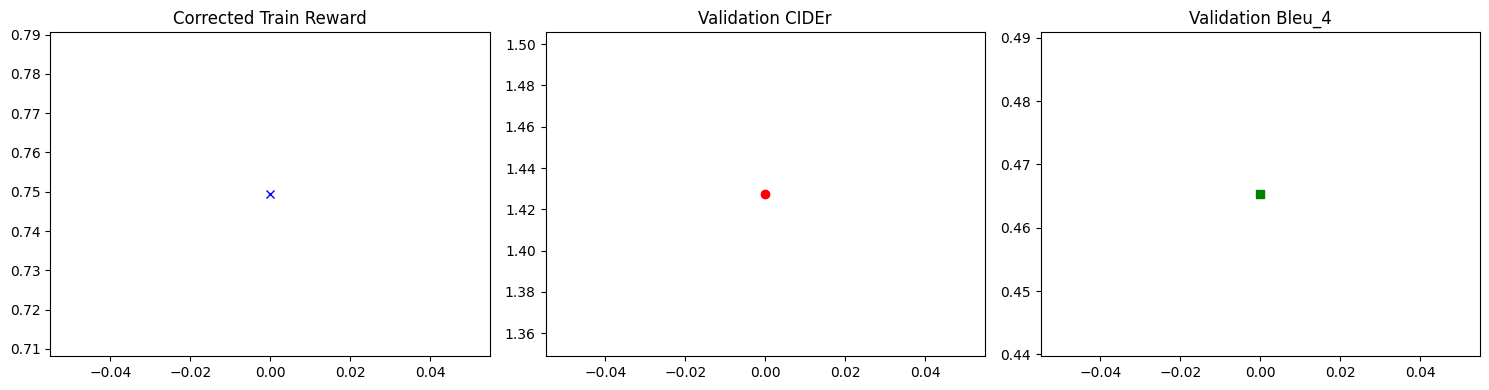

🚀 SCST E2 (Beam=1):   0%|                                                                                     …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 697886.26 tokens per second.
PTBTokenizer tokenized 58185 tokens at 251784.51 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 42.82 s

✅ E2 | CIDEr: 1.3985 | B4: 0.4556


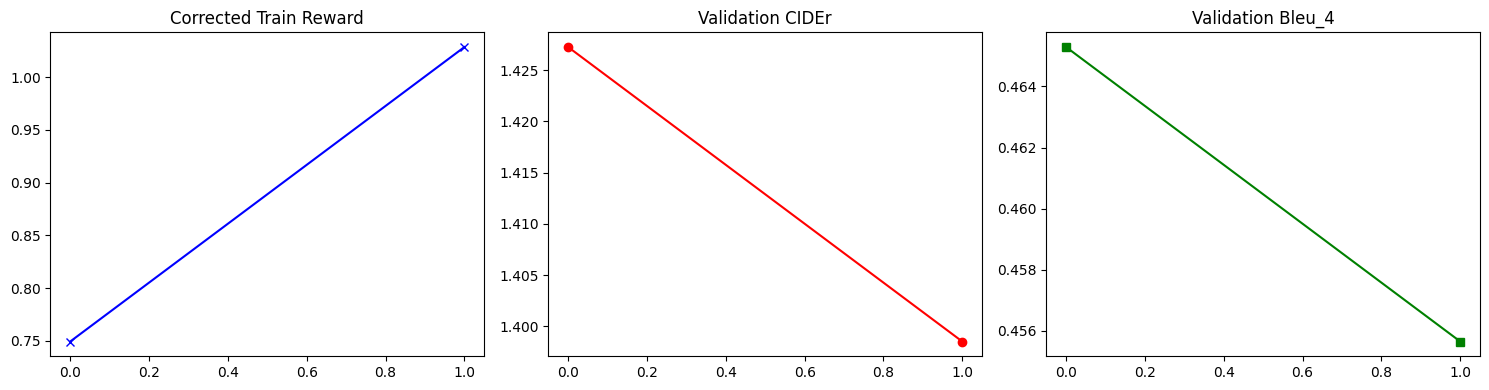

🚀 SCST E3 (Beam=1):   0%|                                                                                     …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 681450.81 tokens per second.
PTBTokenizer tokenized 58107 tokens at 246216.68 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 32.89 s

✅ E3 | CIDEr: 1.4036 | B4: 0.4573


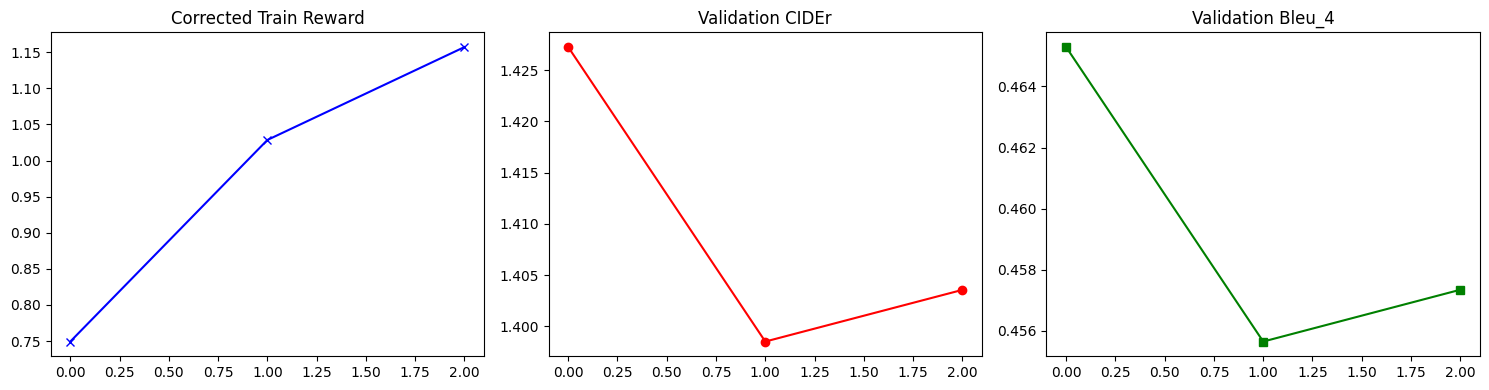

🚀 SCST E4 (Beam=1):   0%|                                                                                     …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 714609.13 tokens per second.
PTBTokenizer tokenized 59183 tokens at 253555.74 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 29.49 s

✅ E4 | CIDEr: 1.4114 | B4: 0.4545


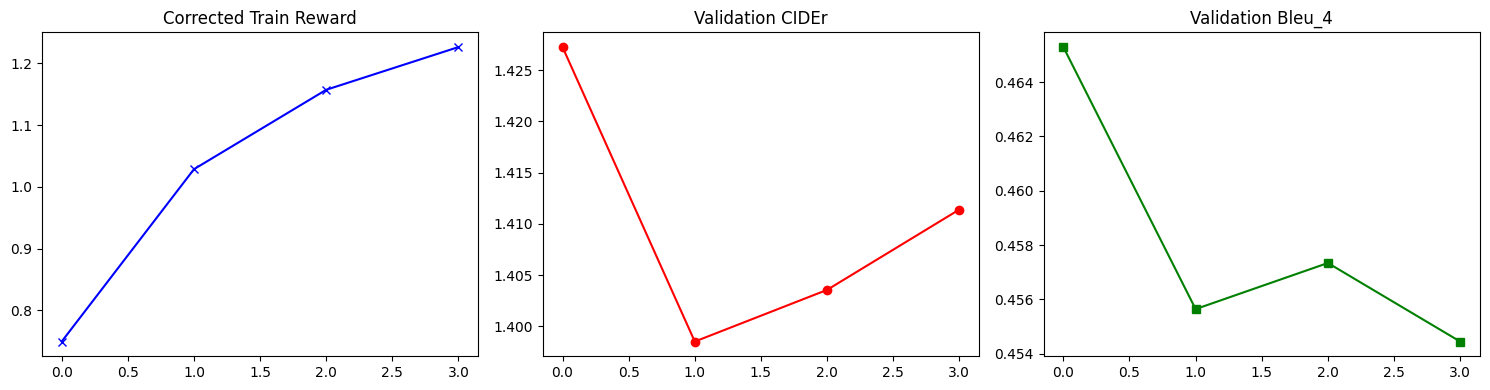

🚀 SCST E5 (Beam=1):   0%|                                                                                     …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 715677.18 tokens per second.
PTBTokenizer tokenized 59200 tokens at 255341.75 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 20.91 s

✅ E5 | CIDEr: 1.4129 | B4: 0.4526


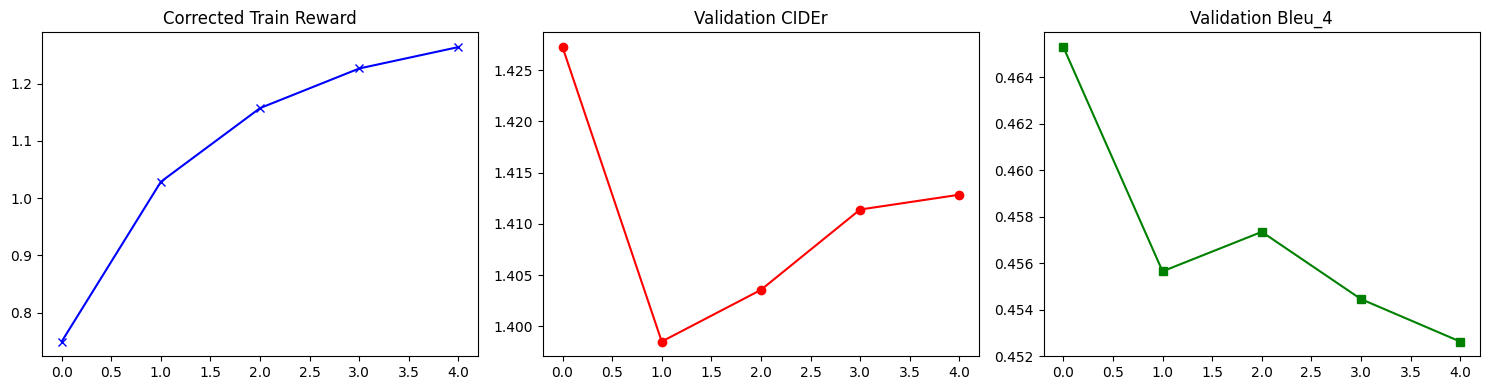

🚀 SCST E6 (Beam=3):   0%|                                                                                     …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 711853.04 tokens per second.
PTBTokenizer tokenized 59265 tokens at 240240.70 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 21.42 s

✅ E6 | CIDEr: 1.4178 | B4: 0.4530


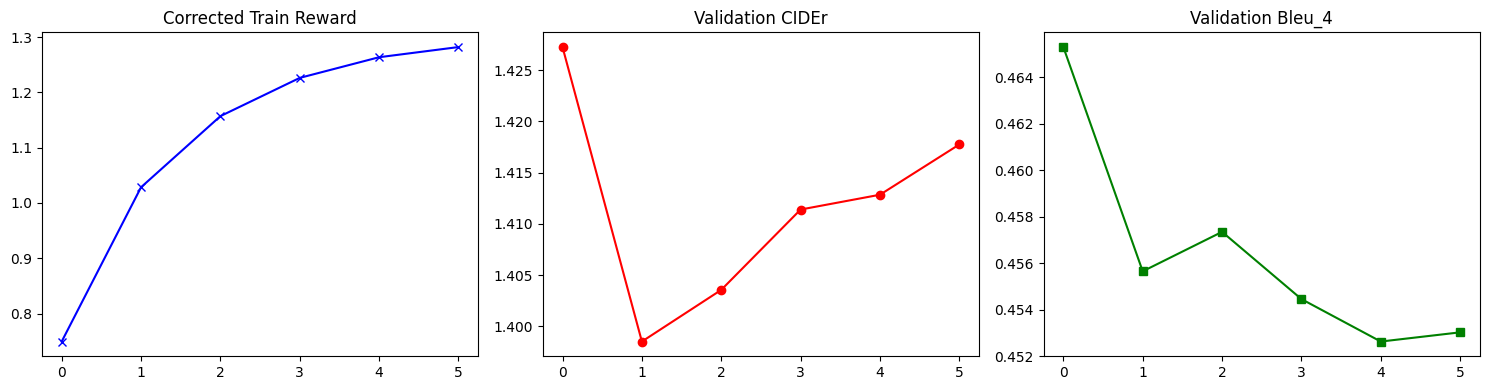

🚀 SCST E7 (Beam=3):   0%|                                                                                     …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 803371.72 tokens per second.
PTBTokenizer tokenized 59804 tokens at 250605.53 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 25.89 s

✅ E7 | CIDEr: 1.4276 | B4: 0.4527


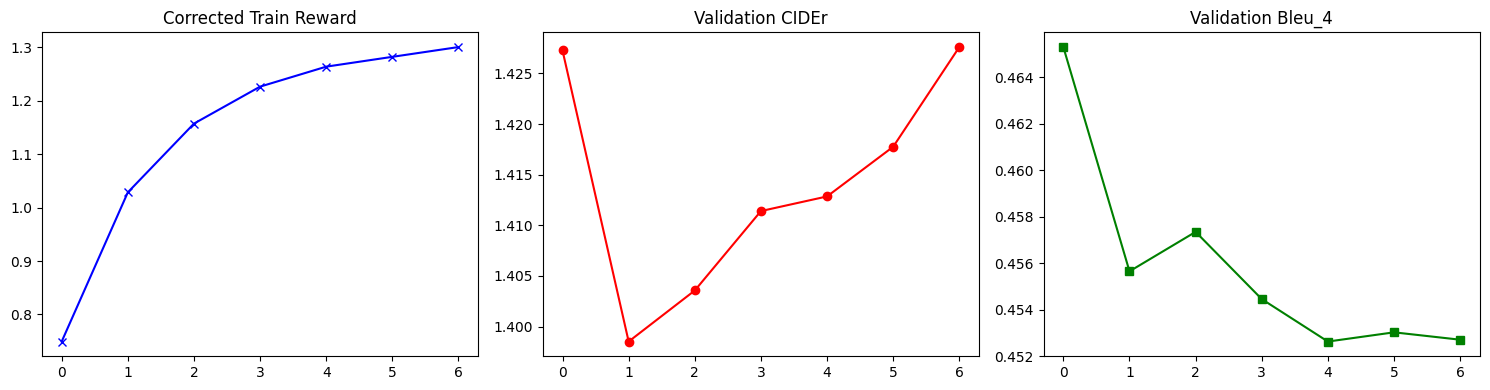

🚀 SCST E8 (Beam=3):   0%|                                                                                     …

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c638c715620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c638c715620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 708657.33 tokens per second.
PTBTokenizer tokenized 59762 tokens at 255291.90 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 18.30 s

✅ E8 | CIDEr: 1.4306 | B4: 0.4555


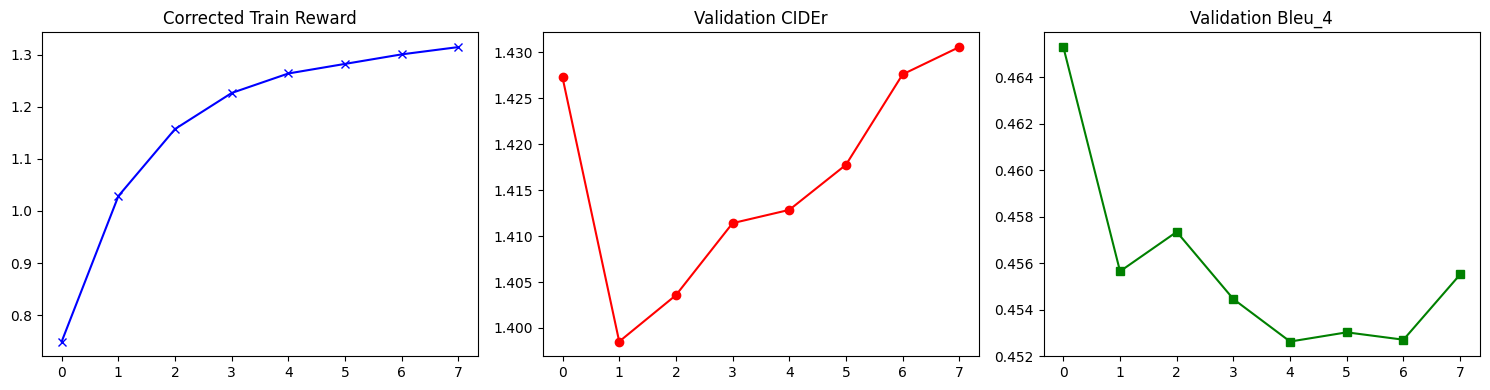

🚀 SCST E9 (Beam=3):   0%|                                                                                     …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 674202.47 tokens per second.
PTBTokenizer tokenized 59604 tokens at 253345.35 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 19.01 s

✅ E9 | CIDEr: 1.4315 | B4: 0.4557


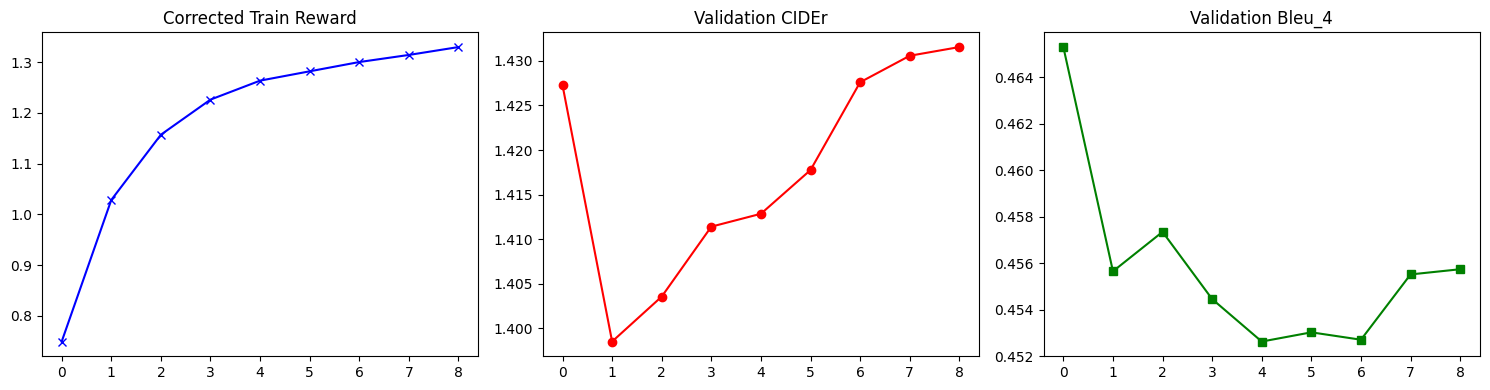

🚀 SCST E10 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 686826.53 tokens per second.
PTBTokenizer tokenized 60277 tokens at 244373.62 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 19.77 s

✅ E10 | CIDEr: 1.4390 | B4: 0.4551


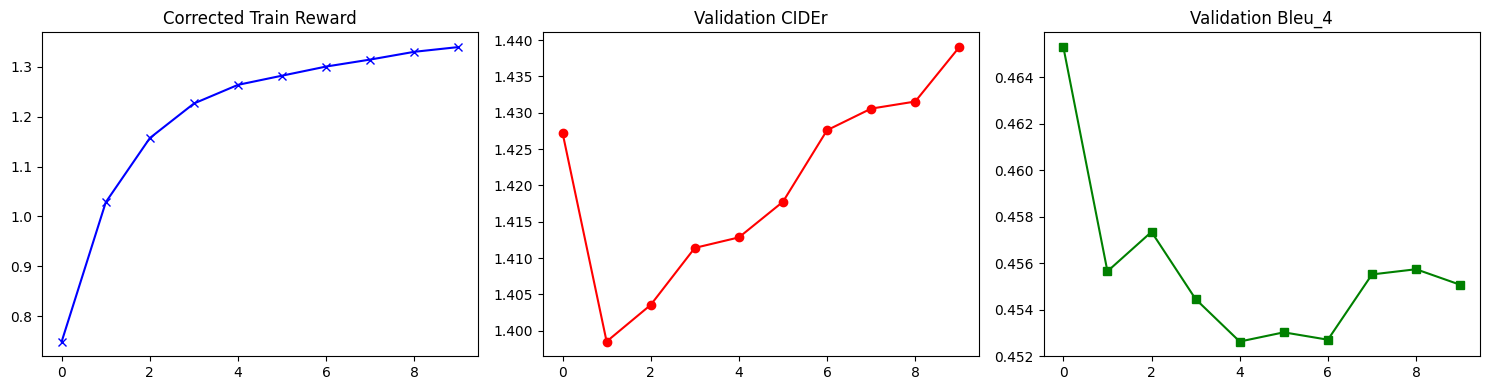

🚀 SCST E11 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 744402.21 tokens per second.
PTBTokenizer tokenized 60061 tokens at 255336.99 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 17.36 s

✅ E11 | CIDEr: 1.4379 | B4: 0.4565


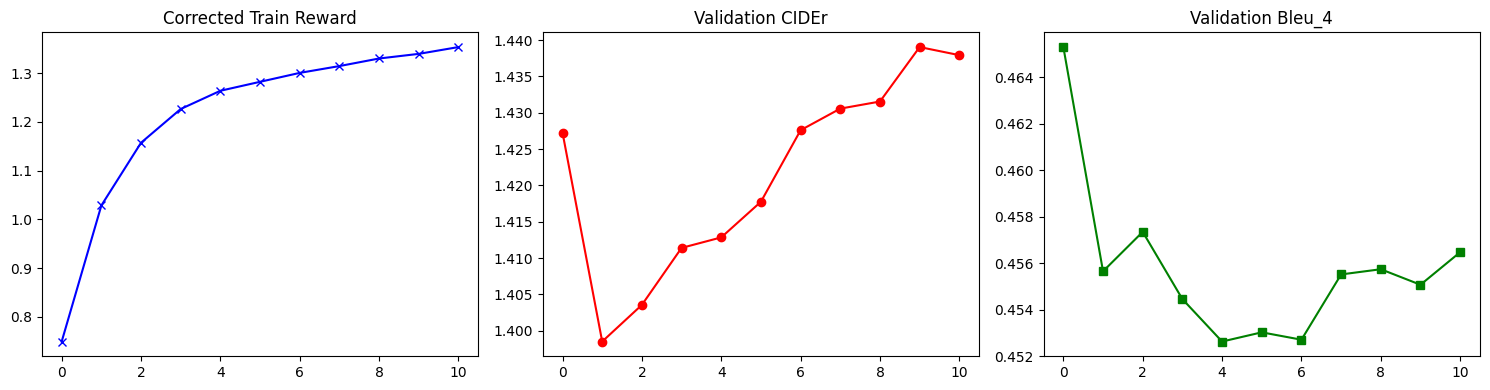

🚀 SCST E12 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 778196.20 tokens per second.
PTBTokenizer tokenized 60337 tokens at 255246.29 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 18.28 s

✅ E12 | CIDEr: 1.4381 | B4: 0.4557


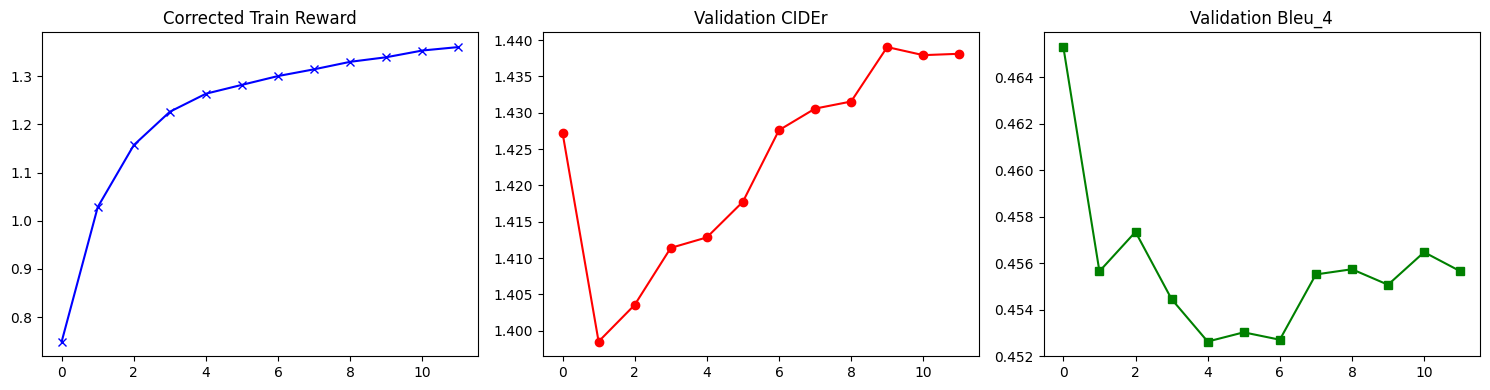

🚀 SCST E13 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 720676.67 tokens per second.
PTBTokenizer tokenized 60044 tokens at 307038.20 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 17.64 s

✅ E13 | CIDEr: 1.4397 | B4: 0.4563


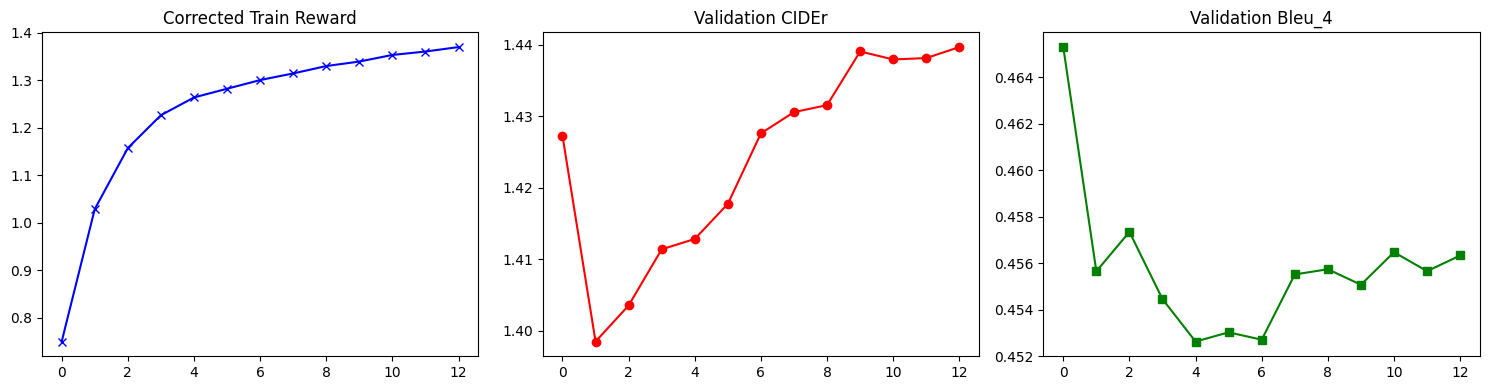

🚀 SCST E14 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 708410.80 tokens per second.
PTBTokenizer tokenized 60244 tokens at 254957.73 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 15.75 s

✅ E14 | CIDEr: 1.4454 | B4: 0.4578


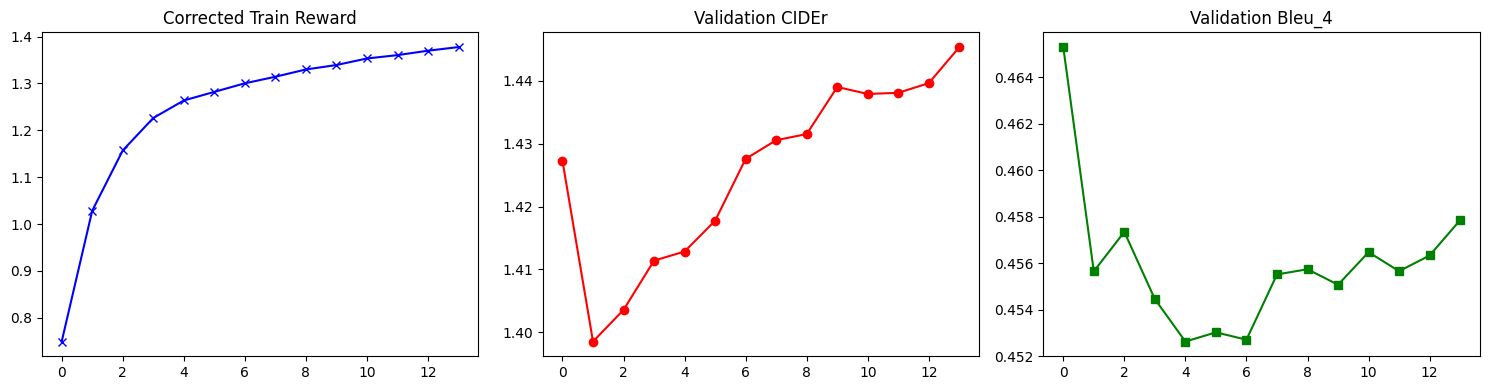

🚀 SCST E15 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 762251.23 tokens per second.
PTBTokenizer tokenized 60436 tokens at 231447.71 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 18.47 s

✅ E15 | CIDEr: 1.4482 | B4: 0.4576


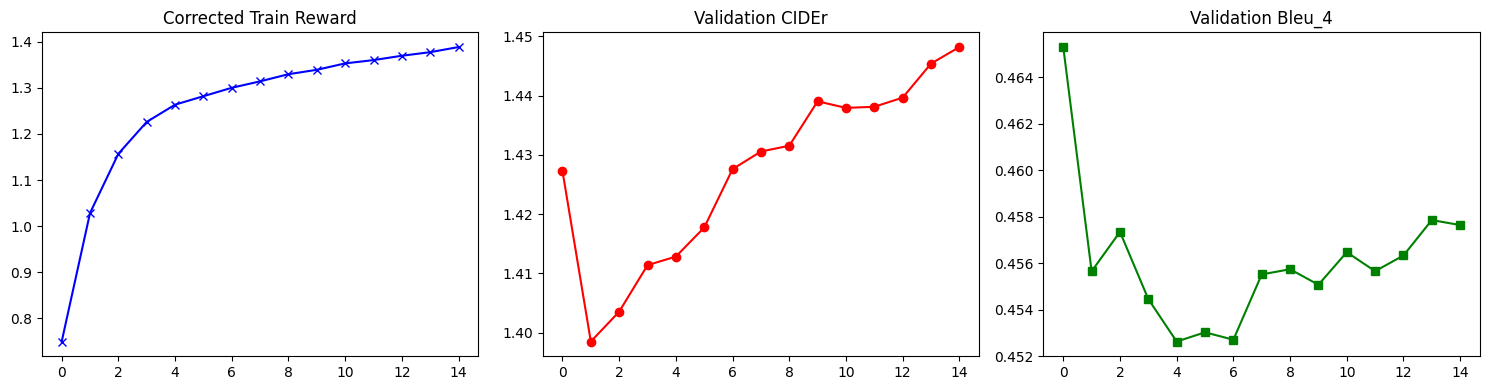

🚀 SCST E16 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 709042.20 tokens per second.
PTBTokenizer tokenized 60452 tokens at 265039.00 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 18.73 s

✅ E16 | CIDEr: 1.4517 | B4: 0.4586


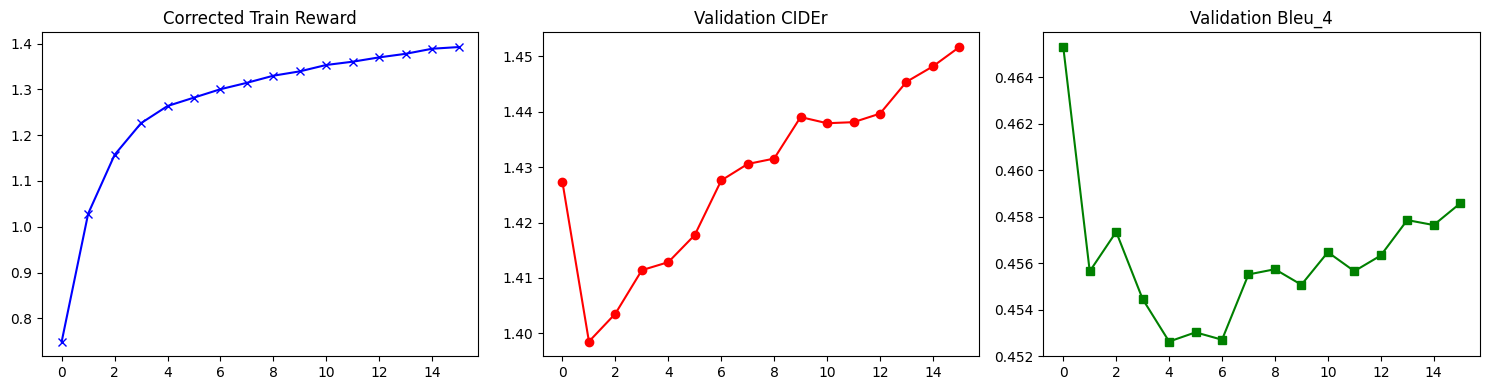

🚀 SCST E17 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 708234.58 tokens per second.
PTBTokenizer tokenized 60371 tokens at 252989.64 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 15.82 s

✅ E17 | CIDEr: 1.4510 | B4: 0.4587


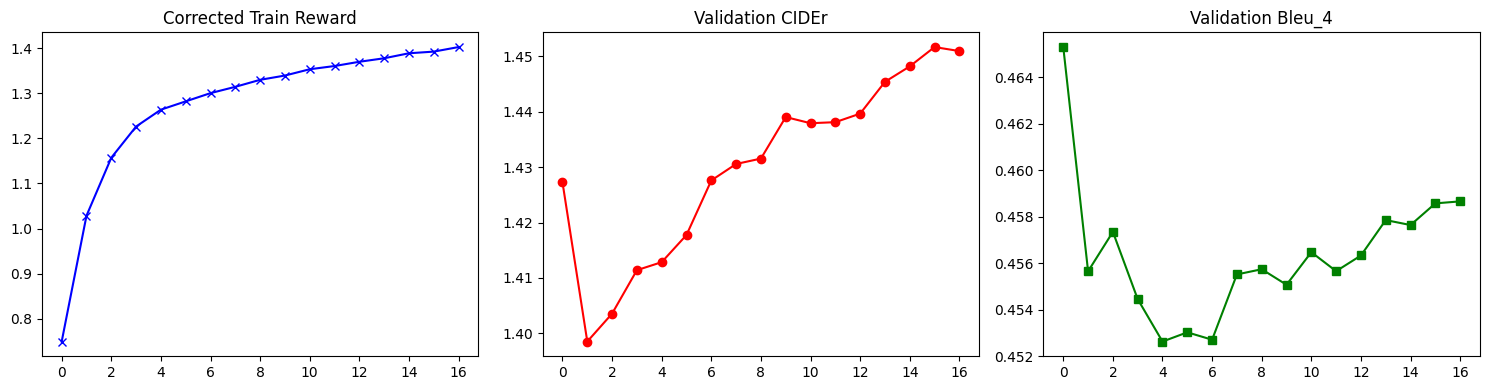

🚀 SCST E18 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 679337.38 tokens per second.
PTBTokenizer tokenized 60437 tokens at 272577.61 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 17.73 s

✅ E18 | CIDEr: 1.4505 | B4: 0.4584


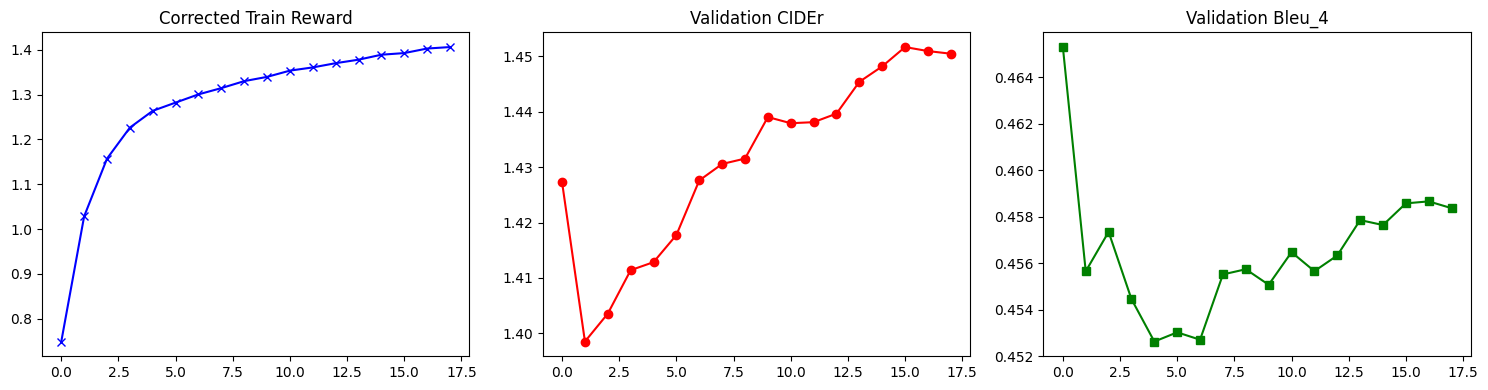

🚀 SCST E19 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 799864.04 tokens per second.
PTBTokenizer tokenized 60683 tokens at 266919.50 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 17.58 s

✅ E19 | CIDEr: 1.4565 | B4: 0.4574


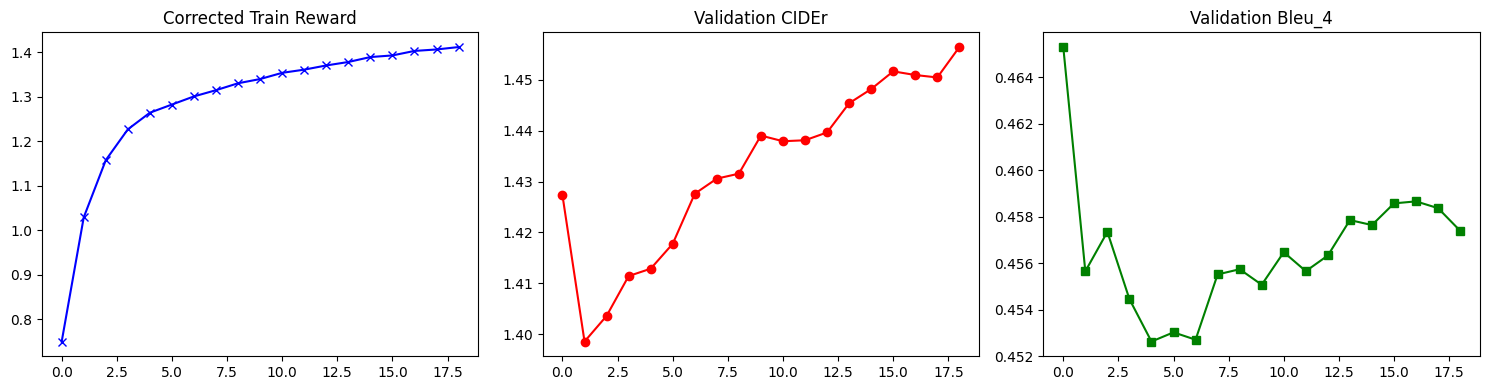

🚀 SCST E20 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 706588.45 tokens per second.
PTBTokenizer tokenized 60468 tokens at 291409.83 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 16.92 s

✅ E20 | CIDEr: 1.4545 | B4: 0.4584


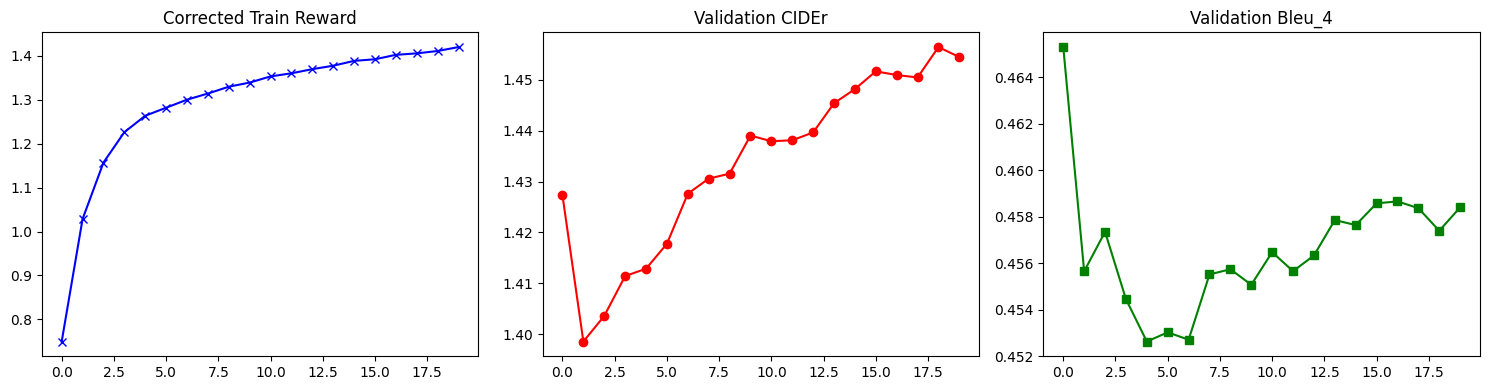

🚀 SCST E21 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 683001.99 tokens per second.
PTBTokenizer tokenized 60988 tokens at 266238.09 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 18.00 s

✅ E21 | CIDEr: 1.4599 | B4: 0.4583


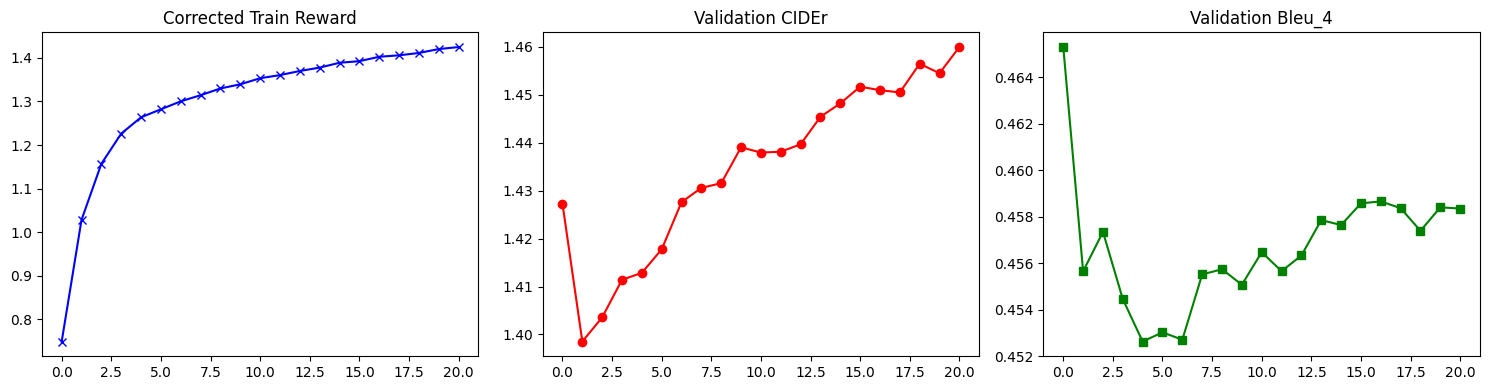

🚀 SCST E22 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 694136.81 tokens per second.
PTBTokenizer tokenized 61057 tokens at 270155.25 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 19.28 s

✅ E22 | CIDEr: 1.4638 | B4: 0.4588


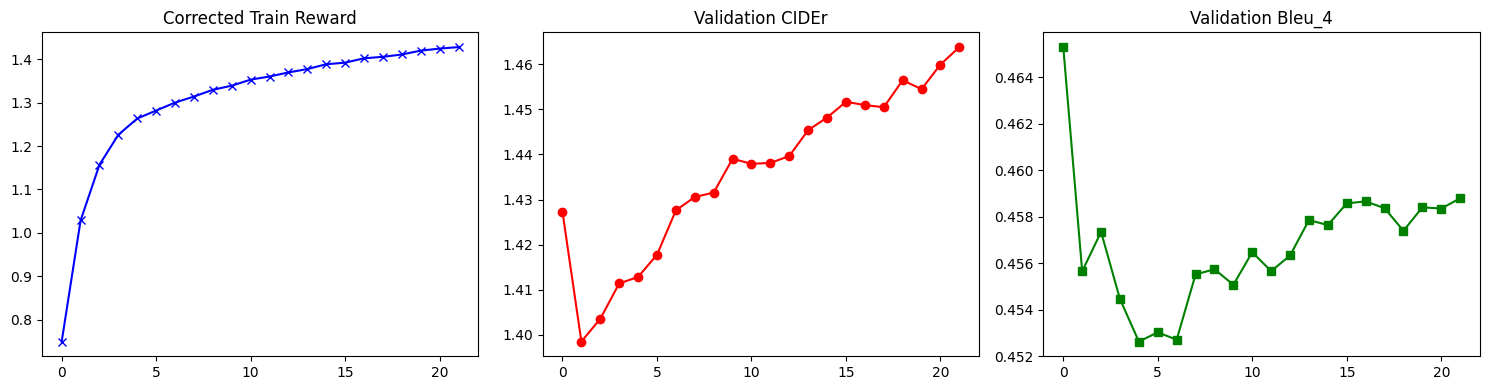

🚀 SCST E23 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 591299.29 tokens per second.
PTBTokenizer tokenized 60726 tokens at 270743.93 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 16.10 s

✅ E23 | CIDEr: 1.4607 | B4: 0.4588


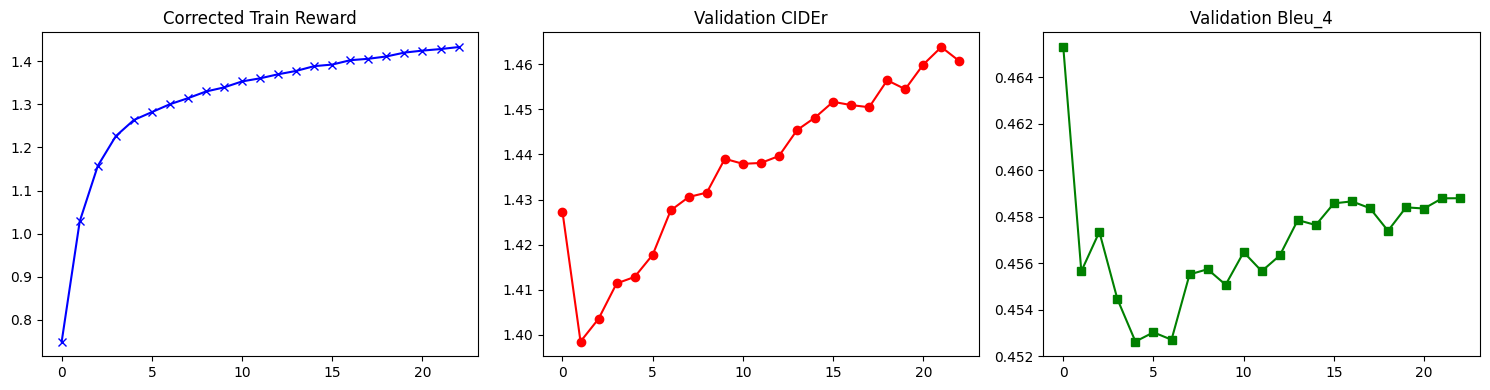

🚀 SCST E24 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 585366.65 tokens per second.
PTBTokenizer tokenized 61088 tokens at 256180.21 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 16.94 s

✅ E24 | CIDEr: 1.4597 | B4: 0.4577


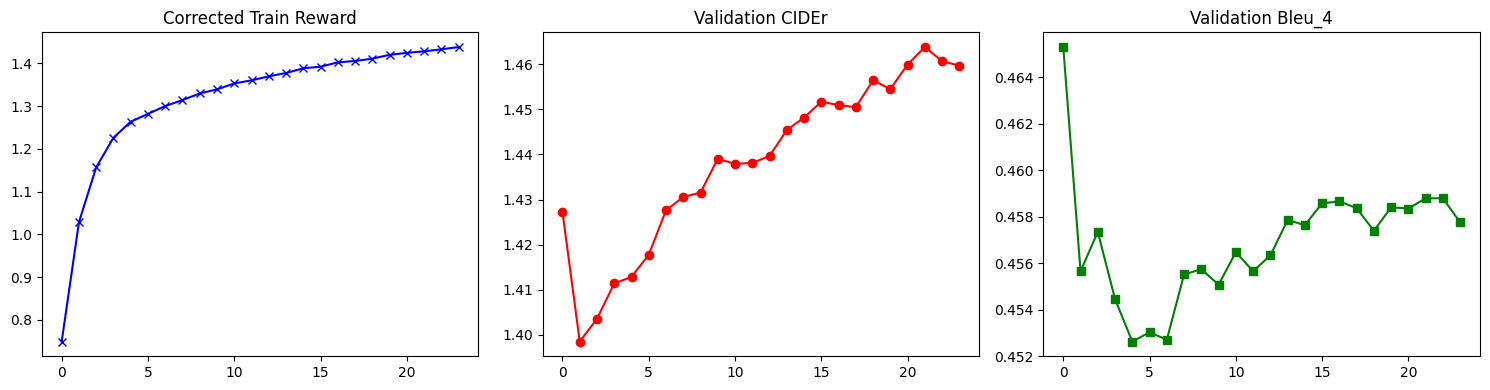

🚀 SCST E25 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 659258.13 tokens per second.
PTBTokenizer tokenized 61236 tokens at 256215.27 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 16.43 s

✅ E25 | CIDEr: 1.4669 | B4: 0.4580


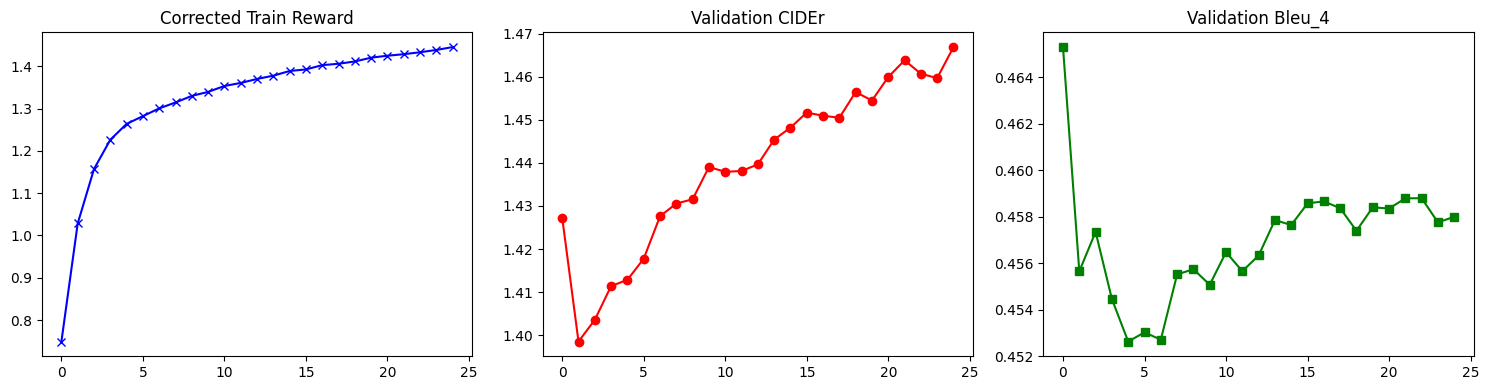

🚀 SCST E26 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 683539.00 tokens per second.
PTBTokenizer tokenized 61317 tokens at 260112.49 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 17.48 s

✅ E26 | CIDEr: 1.4640 | B4: 0.4567


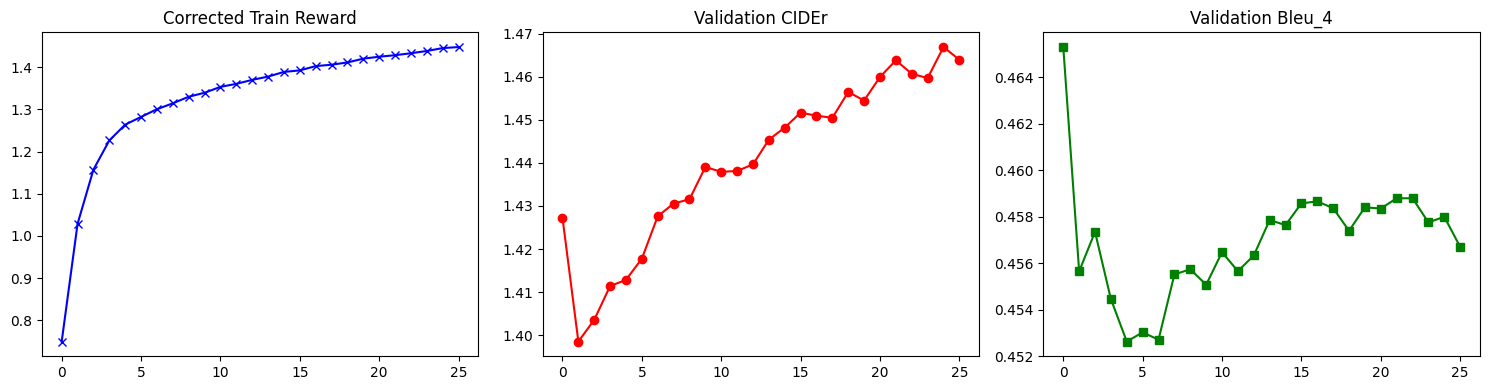

🚀 SCST E27 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 781562.53 tokens per second.
PTBTokenizer tokenized 61288 tokens at 260930.27 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 17.61 s

✅ E27 | CIDEr: 1.4669 | B4: 0.4584


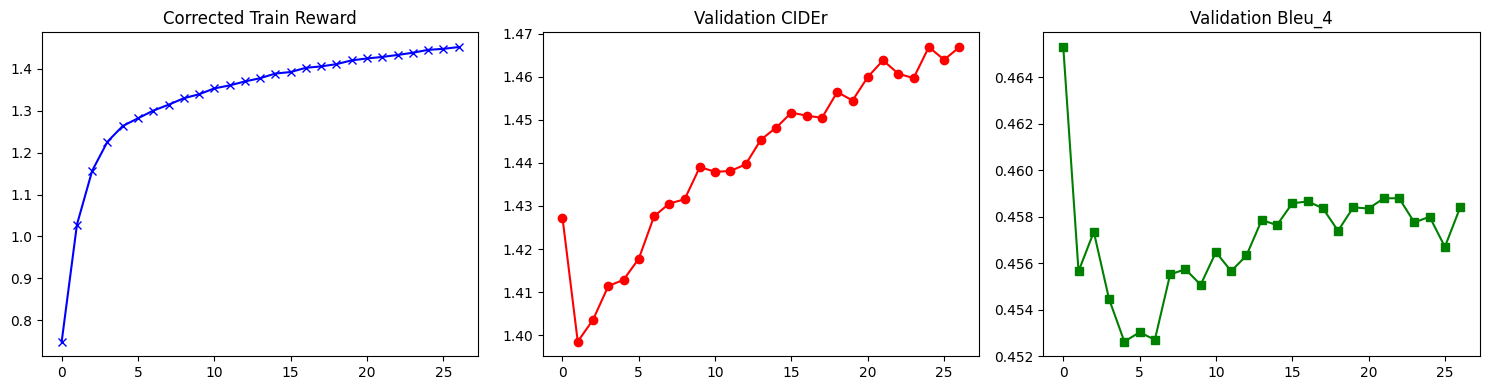

🚀 SCST E28 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 691319.12 tokens per second.
PTBTokenizer tokenized 60988 tokens at 248875.56 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 15.02 s

✅ E28 | CIDEr: 1.4666 | B4: 0.4595


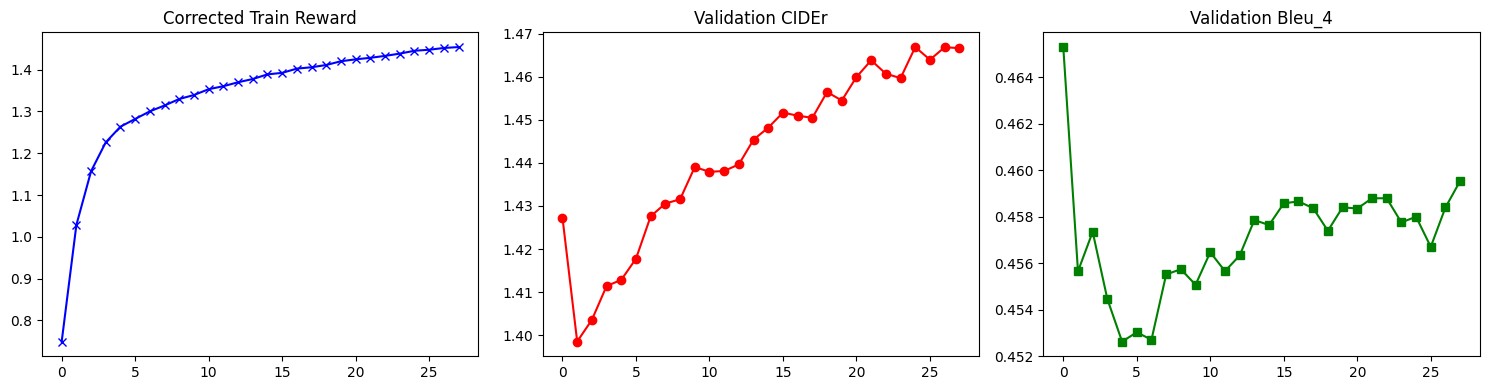

🚀 SCST E29 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 578307.34 tokens per second.
PTBTokenizer tokenized 60923 tokens at 251794.12 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 15.25 s

✅ E29 | CIDEr: 1.4662 | B4: 0.4595


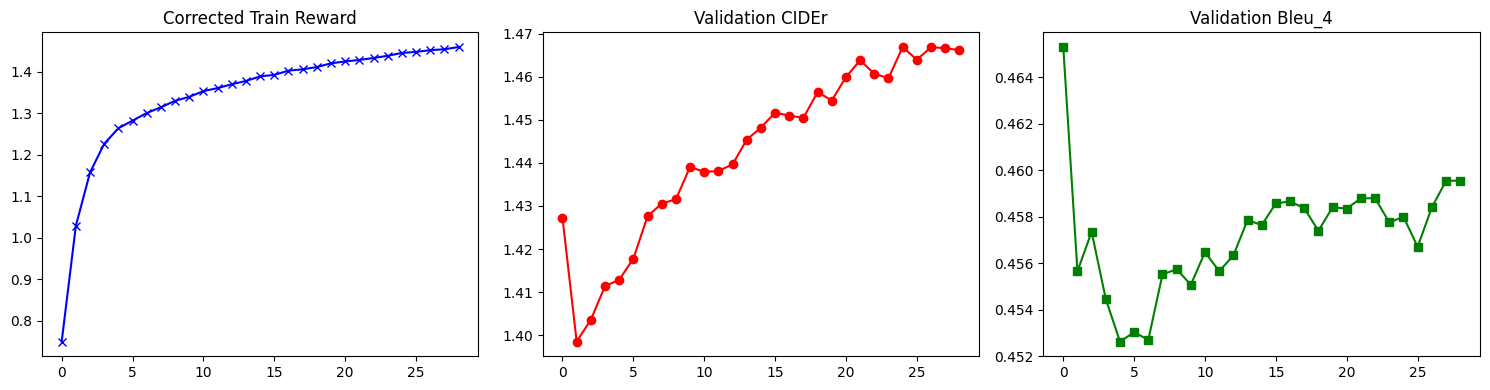

🚀 SCST E30 (Beam=3):   0%|                                                                                    …

Predicting:   0%|          | 0/40 [00:00<?, ?it/s]

PTBTokenizer tokenized 355763 tokens at 582100.35 tokens per second.
PTBTokenizer tokenized 61225 tokens at 305104.26 tokens per second.
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.dists

SPICE evaluation took: 14.01 s

✅ E30 | CIDEr: 1.4706 | B4: 0.4589


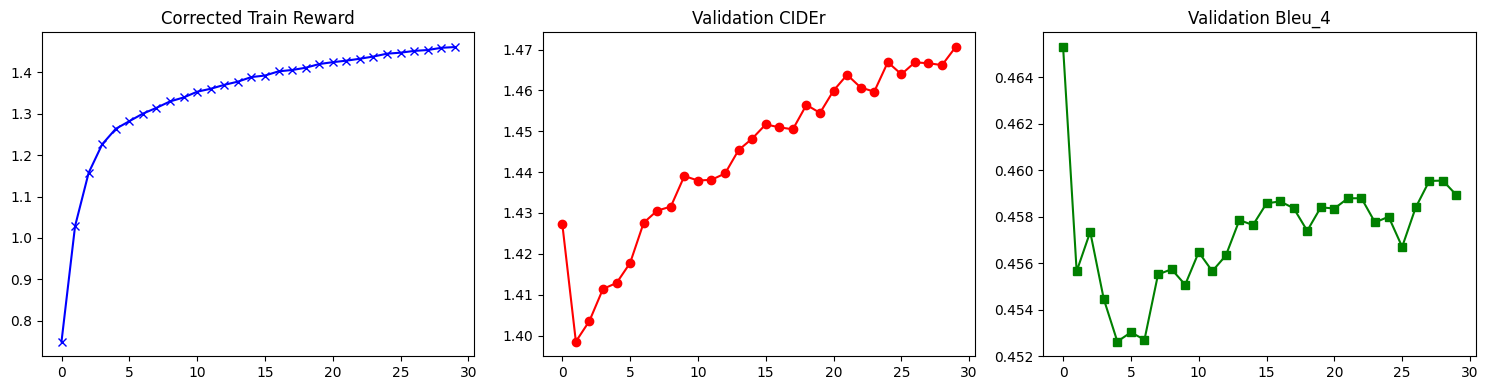

In [ ]:


# --- 0. KHỞI TẠO CIDER SCORER (FIX LỖI NAMEERROR) ---
cider_scorer = Cider()

# --- 1. HÀM TÍNH REWARD VECTORIZED ---
def get_scst_reward_full(refs, sampled, baseline, scorer):
    n = len(sampled)
    res = {i: [sampled[i]] for i in range(n)}
    for i in range(n): res[i + n] = [baseline[i]]
    gts = {i: r if isinstance(r, list) else [r] for i, r in enumerate(refs)}
    for i in range(n): gts[i + n] = gts[i]
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        _, all_scores = scorer.compute_score(gts, res)
    all_scores = torch.tensor(all_scores, dtype=torch.float32)
    return all_scores[:n], all_scores[n:]

# --- 2. CẤU HÌNH SIÊU TỐI ƯU ---
SCST_EPOCHS = 30
LR_SCST = 1e-5           
SCST_MAXLEN = 20         # Rút ngắn MaxLen để tăng tốc xử lý
scaler = GradScaler('cuda')
optim = AdamW(model.parameters(), lr=LR_SCST, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optim, mode='max', factor=0.5, patience=2)

history = {'train_reward': [], 'val_cider': [], 'val_bleu4': []}
best_cider_val = 0.0

# --- 3. VÒNG LẶP HUẤN LUYỆN ---
for epoch in range(1, SCST_EPOCHS + 1):
    model.train()
    # Tự động điều chỉnh Beam: E1-E5 dùng Greedy (Beam=1) để chạy cực nhanh
    current_beam = 1 if epoch <= 5 else 3 
    batch_rewards = []
    
    pbar = tqdm(enumerate(scst_dl), total=len(scst_dl), 
                desc=f"🚀 SCST E{epoch} (Beam={current_beam})", ncols=160)
    
    for bidx, (feats, refs) in pbar:
        feats = feats.to(DEVICE, non_blocking=True)
        B = feats.size(0)

        # BƯỚC 1: BASELINE (Tối ưu hóa tốc độ với Mixed Precision)
        model.eval()
        with torch.no_grad(), autocast('cuda'):
            if current_beam == 1:
                base_ids = model.greedy_search(feats, max_len=SCST_MAXLEN, bos=BOS, eos=EOS, pad=PAD)
            else:
                base_ids = model.beam_search(feats, beam_size=current_beam, max_len=SCST_MAXLEN, 
                                            bos=BOS, eos=EOS, pad=PAD, length_penalty=0.8, no_repeat_ngram_size=2)
            baseline_texts = [decode_min(base_ids[i]) for i in range(B)]
            
        # BƯỚC 2: SAMPLE (Policy Gradient Exploration)
        model.train()
        with autocast('cuda'):
            f = model.feat_ln(model.feat_proj(feats))
            f_mean = f.mean(1)
            h_att = feats.new_zeros(B, 512); c_att = feats.new_zeros(B, 512)
            h_lang = feats.new_zeros(B, 512); c_lang = feats.new_zeros(B, 512)
            prev = feats.new_full((B,), BOS, dtype=torch.long)
            
            logp_sums, sampled_tokens = feats.new_zeros(B), []
            finished = torch.zeros(B, dtype=torch.bool, device=DEVICE)

            for t in range(SCST_MAXLEN):
                w_t = model.emb(prev)
                h_att, c_att = model.att_lstm(torch.cat([w_t, f_mean, h_lang], -1), (h_att, c_att))
                v_hat, _ = model._attend(f, h_att)
                h_lang, c_lang = model.lang_lstm(torch.cat([v_hat, h_att], -1), (h_lang, c_lang))
                logp = F.log_softmax(model.out(model.dropout(h_lang)), dim=-1)
                
                with torch.no_grad():
                    next_tok = torch.multinomial(torch.exp(logp), 1).squeeze(1)
                
                logp_sums += logp.gather(1, next_tok.unsqueeze(1)).squeeze(1) * (~finished).float()
                sampled_tokens.append(next_tok.unsqueeze(1))
                finished |= (next_tok == EOS); prev = next_tok
                if finished.all(): break

            sampled_texts = [decode_min(torch.cat(sampled_tokens, 1)[i]) for i in range(B)]

        # BƯỚC 3: REWARD & UPDATE (Tối ưu hóa tính toán CPU-GPU)
        reward_s, reward_b = get_scst_reward_full(refs, sampled_texts, baseline_texts, cider_scorer)
        adv = (reward_s - reward_b).to(DEVICE)
        loss = -(adv.detach() * logp_sums).mean()

        optim.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.unscale_(optim)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # Clip để tránh nổ Gradient
        scaler.step(optim)
        scaler.update()

        # UI: HIỂN THỊ TRỰC QUAN
        batch_rewards.append(reward_s.mean().item())
        win_rate = (adv > 0).float().mean().item() * 100
        pbar.set_postfix({
            "Rew": f"{np.mean(batch_rewards[-20:]):.3f}",
            "Win": f"{win_rate:.1f}%",
            "Mem": f"{torch.cuda.memory_reserved()/1E9:.1f}GB"
        })

    # --- 4. VAL & PLOT (Theo dõi tiến trình hội tụ) ---
    history['train_reward'].append(np.mean(batch_rewards))
    val_res = f"/kaggle/working/val_e{epoch}.json"
    predict_from_loader(val_img_dl, val_res, beam=5)
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        metrics = coco_eval(VAL_JSON, val_res)
    
    cur_cider = metrics.get('CIDEr', 0)
    history['val_cider'].append(cur_cider); history['val_bleu4'].append(metrics.get('Bleu_4', 0))
    print(f"\n✅ E{epoch} | CIDEr: {cur_cider:.4f} | B4: {metrics.get('Bleu_4', 0):.4f}")

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); plt.plot(history['train_reward'], 'b-x'); plt.title('Corrected Train Reward')
    plt.subplot(1, 3, 2); plt.plot(history['val_cider'], 'r-o'); plt.title('Validation CIDEr')
    plt.subplot(1, 3, 3); plt.plot(history['val_bleu4'], 'g-s'); plt.title('Validation Bleu_4')
    plt.tight_layout(); plt.show()

    scheduler.step(cur_cider)
    if cur_cider > best_cider_val:
        best_cider_val = cur_cider
        torch.save(model.state_dict(), "/kaggle/working/butd_scst_optimized.pt")